#**`------THE MASTERY PROJECT------`**

#TravelTide Rewards: Customer Segmentation Analysis

## Company Overview

## `The TravelTide Company`

E-booking startup TravelTide is a hot new player in the online travel industry. It has experienced steady growth since it was founded at the tail end of the COVID-19 pandemic (2021-04) on the strength of its data aggregation and search technology, which is best in class. Feedback from the customers has shown - and industry analysts agree - that TravelTide customers have access to the largest travel inventory in the e-booking space!

Following the startup playbook, TravelTide has maintained a hyper-focus on building an unfair advantage along a limited number of dimensions - in this case, building the biggest travel inventory and making it easily searchable. Because of this narrow focus, certain aspects of the TravelTide customer experience are underdeveloped, resulting in poor customer retention. CEO Kevin Talanick is very motivated to retain and add value to existing customers with a Marketing strategy built on a solid understanding of customer behavior



##Project Goal

The goal of the project is to improve the TravelTide rewards program's relevance by analyzing the full dataset (demographics, online activity, and bookings). This analysis will define actionable customer segments based on their engagement and travel patterns, ultimately providing the marketing team with clear insights to personalize loyalty perks and boost overall engagement.



## Project Workflow 

This analysis follows a structured process, including data preparation, exploratory analysis, feature engineering, segmentation modeling and segmentation insights.

##1. Data Retrieval and Preliminary Review

In [0]:
# 1.1 Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")


In [0]:
# 1.2 Connect to Database & Load Tables into Spark DataFrames

# Database connection URL
traveltide_url = "jdbc:postgresql://ep-noisy-flower-846766.us-east-2.aws.neon.tech/TravelTide"

# Database connection properties
properties = {
    "user": "Test"
    , "password": "bQNxVzJL4g6u"
    , "driver": "org.postgresql.Driver"
}

# Load PostgreSQL table metadata into a Spark DataFrame
traveltide_metadata = spark.read.jdbc(
    url=traveltide_url
    , table="information_schema.tables"
    , properties=properties
)

# Filter to user-defined tables in the 'public' schema
table_names = traveltide_metadata.filter(traveltide_metadata.table_schema == "public")

# Show table names
table_names.select("table_name").show(truncate=False)

+----------+
|table_name|
+----------+
|sessions  |
|flights   |
|users     |
|hotels    |
+----------+



In [0]:
# Create reusable function to load tables into Spark DataFrames
def load_and_inspect_table(table_name):
  # Return table as Spark DataFrame
  spark_df = spark.read.jdbc(
    url=traveltide_url
    , table=table_name
    , properties=properties
  )

  # Inspect shape of DataFrame
  print(f"{table_name.upper()} SHAPE:")
  print(f"Column: ", len(spark_df.columns))
  print(f"Row: ", spark_df.count())
  
  # Show DataFrame column names
  print(f"\n{table_name.upper()} COLUMN NAMES:")
  print(spark_df.columns)
  
  return spark_df

In [0]:
sessions_spark = load_and_inspect_table("sessions")

SESSIONS SHAPE:
Column:  13
Row:  5408063

SESSIONS COLUMN NAMES:
['session_id', 'user_id', 'trip_id', 'session_start', 'session_end', 'flight_discount', 'hotel_discount', 'flight_discount_amount', 'hotel_discount_amount', 'flight_booked', 'hotel_booked', 'page_clicks', 'cancellation']


In [0]:
flights_spark = load_and_inspect_table("flights")

FLIGHTS SHAPE:
Column:  13
Row:  1901038

FLIGHTS COLUMN NAMES:
['trip_id', 'origin_airport', 'destination', 'destination_airport', 'seats', 'return_flight_booked', 'departure_time', 'return_time', 'checked_bags', 'trip_airline', 'destination_airport_lat', 'destination_airport_lon', 'base_fare_usd']


In [0]:
users_spark = load_and_inspect_table("users")

USERS SHAPE:
Column:  11
Row:  1020926

USERS COLUMN NAMES:
['user_id', 'birthdate', 'gender', 'married', 'has_children', 'home_country', 'home_city', 'home_airport', 'home_airport_lat', 'home_airport_lon', 'sign_up_date']


In [0]:
hotels_spark = load_and_inspect_table("hotels")

HOTELS SHAPE:
Column:  7
Row:  1918617

HOTELS COLUMN NAMES:
['trip_id', 'hotel_name', 'nights', 'rooms', 'check_in_time', 'check_out_time', 'hotel_per_room_usd']


In [0]:
# 1.3 Create SQL Query to Filter Sessions Table

# Filter to only include sessions that started after 2023-01-04
# Filter to only include users with more than 7 sessions
# Join filtered sessions with users, flights, and hotels for identified users

# Return filtered sql dataset as a Spark DataFrame
filtered_sessions_spark = spark.sql("""
WITH
  -- Filter sessions that started after 2023-01-04
  filtered_sessions AS (
    SELECT *
    FROM sessions_spark
    WHERE session_start > '2023-01-04'
    ),
  -- Identify users with more than 7 sessions
  filtered_users AS (
    SELECT
      user_id
      , COUNT(*) AS session_count
    FROM filtered_sessions
    GROUP BY user_id
    HAVING COUNT(*) > 7
    ),
  -- Join filtered sessions with users, flights, and hotels for identified users
  session_base AS (
    SELECT
      -- Columns from "sessions" table
      s.session_id
      , s.user_id
      , s.trip_id
      , s.session_start
      , s.session_end
      , s.page_clicks
      , s.flight_discount
      , s.flight_discount_amount
      , s.flight_booked
      , s.hotel_discount
      , s.hotel_discount_amount
      , s.hotel_booked
      , s.cancellation

      -- Columns from "users" table
      , u.birthdate
      , u.gender
      , u.married
      , u.has_children
      , u.home_country
      , u.home_city
      , u.home_airport
      , u.home_airport_lat
      , u.home_airport_lon
      , u.sign_up_date

      -- Columns from "flights" table
      , f.origin_airport
      , f.destination
      , f.destination_airport
      , f.seats
      , f.return_flight_booked
      , f.departure_time
      , f.return_time
      , f.checked_bags
      , f.trip_airline
      , f.destination_airport_lat
      , f.destination_airport_lon
      , f.base_fare_usd 

      -- Columns from "hotels" table
      , h.hotel_name
      , h.nights
      , h.rooms
      , h.check_in_time
      , h.check_out_time
      , h.hotel_per_room_usd AS hotel_base_nightly_rate_usd

    FROM filtered_sessions s
    INNER JOIN users_spark u ON s.user_id = u.user_id
    LEFT JOIN flights_spark f ON s.trip_id = f.trip_id
    LEFT JOIN hotels_spark h ON s.trip_id = h.trip_id
    WHERE s.user_id IN (
      SELECT user_id
      FROM filtered_users
      )
    )
SELECT *
FROM session_base
""")

# Convert Spark DataFrame to Pandas DataFrame
filtered_sessions_pd = filtered_sessions_spark.toPandas()

In [0]:
# 1.4 Preview of the Filtered Sessions Table

filtered_sessions_pd.head()

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_base_nightly_rate_usd
0,669140-1d20431c5d7547d786c38f017e3f664e,669140,669140-574a1beeb927431fbf28ebcce23789e1,2023-05-09 10:08:00,2023-05-09 10:10:16,18,True,0.15,True,False,NaN,True,False,1960-07-06,F,True,True,usa,detroit,YIP,42.238,-83.530,2023-03-17,YIP,winnipeg,YWG,1.0,True,2023-05-14 14:00:00,2023-05-18 14:00:00,2.0,Air Canada,50.056,-97.032,228.64,Banyan Tree - winnipeg,2.0,1.0,2023-05-14 17:41:24.000,2023-05-17 11:00:00,30.0
1,547266-d7a49b3a0306490898a96303c283ea03,547266,547266-6ef996f5a99144469482944c919d9659,2023-06-15 13:54:00,2023-06-15 13:55:21,11,False,NaN,False,False,NaN,True,False,1968-07-05,F,True,False,canada,winnipeg,YWG,49.910,-97.234,2023-01-23,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,NH Hotel - oklahoma city,2.0,1.0,2023-06-19 11:00:00.000,2023-06-21 11:00:00,109.0
2,513860-067c1bb7f1dd441091545540a4a9eec5,513860,513860-d26045169c564e53919e817f36983d70,2023-06-03 13:16:00,2023-06-03 13:20:03,33,False,NaN,True,False,NaN,True,False,1959-08-09,F,True,False,canada,montreal,YUL,45.468,-73.741,2023-01-06,YUL,fresno,FAT,2.0,True,2023-06-12 16:00:00,2023-06-15 16:00:00,1.0,United Airlines,36.776,-119.718,1296.76,Accor - fresno,1.0,2.0,2023-06-12 22:53:32.730,2023-06-14 11:00:00,112.0
3,529801-439b3a199e2647b1a59ee3216d07b49d,529801,529801-088a63ebf1894918a711fd41c9db381e,2023-06-08 12:53:00,2023-06-08 12:56:16,27,False,NaN,False,False,NaN,True,False,1981-01-08,F,False,True,usa,chicago,MDW,41.786,-87.752,2023-01-14,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,Rosewood - san francisco,9.0,1.0,2023-06-19 11:00:00.000,2023-06-28 11:00:00,108.0
4,560245-683b8d92cd3d4a4fae06ab78f1c4fb9a,560245,560245-c4ea0f1bfa074ad089eafbdbbf6add36,2023-05-02 20:53:00,2023-05-02 20:56:22,27,False,NaN,True,False,NaN,True,False,1980-10-26,F,False,True,usa,san jose,SJC,37.362,-121.929,2023-01-29,SJC,philadelphia,PNE,3.0,True,2023-05-12 09:00:00,2023-05-14 09:00:00,0.0,American Airlines,39.872,-75.241,2345.76,Banyan Tree - philadelphia,0.0,3.0,2023-05-12 16:01:28.335,2023-05-13 11:00:00,88.0


In [0]:
# 1.5 Inspect Data Shape 

print(f"FILTERED_SESSIONS SHAPE:")
print(f"Column: ", len(filtered_sessions_pd.columns))
print(f"Row: ", filtered_sessions_pd.shape[0])

FILTERED_SESSIONS SHAPE:
Column:  41
Row:  49211


In [0]:
# 1.6 Inspect Data Type 

filtered_sessions_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49211 entries, 0 to 49210
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   session_id                   49211 non-null  object        
 1   user_id                      49211 non-null  int64         
 2   trip_id                      16702 non-null  object        
 3   session_start                49211 non-null  datetime64[ns]
 4   session_end                  49211 non-null  datetime64[ns]
 5   page_clicks                  49211 non-null  int64         
 6   flight_discount              49211 non-null  bool          
 7   flight_discount_amount       8282 non-null   float64       
 8   flight_booked                49211 non-null  bool          
 9   hotel_discount               49211 non-null  bool          
 10  hotel_discount_amount        6205 non-null   float64       
 11  hotel_booked                 49211 non-nu

## 2. Data Cleaning

In [0]:
# 2.1 Indentify Missing Values

filtered_sessions_pd.isna().sum().sort_values(ascending=False)

hotel_discount_amount          43006
flight_discount_amount         40929
return_time                    35559
destination_airport_lon        34941
destination_airport_lat        34941
destination                    34941
destination_airport            34941
seats                          34941
return_flight_booked           34941
departure_time                 34941
checked_bags                   34941
trip_airline                   34941
origin_airport                 34941
base_fare_usd                  34941
hotel_name                     34485
nights                         34485
rooms                          34485
check_in_time                  34485
check_out_time                 34485
hotel_base_nightly_rate_usd    34485
trip_id                        32509
sign_up_date                       0
session_id                         0
home_airport_lon                   0
user_id                            0
session_start                      0
session_end                        0
p

The missing values in our session data occurr when a booking did not take place. Since this is useful for our analysis, we proceed without imputation. 

In [0]:
# 2.2 Detect Duplicated Rows 

print(f"Number of duplicated rows: {filtered_sessions_pd.duplicated().sum()}")

Number of duplicated rows: 0


No duplicated rows are found. Dataset contains only unique records.

In [0]:
# 2.3 View Summary Statistics

# Define numeric columns to view statistics
numeric_cols = [
      "flight_discount_amount"
    , "hotel_discount_amount"
    , "seats"
    , "checked_bags"
    , "base_fare_usd"
    , "nights"
    , "rooms"
    , "page_clicks"
    , "hotel_base_nightly_rate_usd"
]

# Generate summary statistics
filtered_sessions_pd[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
flight_discount_amount,8282.0,0.139864,0.083914,0.05,0.1000,0.100,0.2000,0.60
hotel_discount_amount,6205.0,0.112192,0.062119,0.05,0.0500,0.100,0.1500,0.45
seats,14270.0,1.215207,0.585891,1.00,1.0000,1.000,1.0000,8.00
checked_bags,14270.0,0.592922,0.677641,0.00,0.0000,1.000,1.0000,8.00
base_fare_usd,14270.0,525.901390,818.296468,2.41,200.4325,381.765,600.6325,21548.04
nights,14726.0,3.672484,3.806717,-2.00,1.0000,2.000,5.0000,43.00
rooms,14726.0,1.194554,0.499344,1.00,1.0000,1.000,1.0000,4.00
page_clicks,49211.0,17.588791,21.495987,1.00,6.0000,13.000,22.0000,566.00
hotel_base_nightly_rate_usd,14726.0,177.937390,118.334569,17.00,99.0000,148.000,222.0000,1376.00


Most users book single seats and rooms, with median values of 1 for both. The median for purchase metrics (flight and hotel discounts, base fares, nightly rates) is not high, indicating that most sessions do not involve high-value purchases. However, the maximum values for flight fares and hotel stays are outliers, suggesting a few users make very large purchases. 
The negative minimum value for "nights" should be addressed, as it is not logically possible to have a negative hotel stay duration.



In [0]:
# Investigate nights column

# Create a flag for invalid date logic
filtered_sessions_pd["invalid_dates"] = (
    filtered_sessions_pd["check_out_time"] <= filtered_sessions_pd["check_in_time"]
)

# Define columns to inspect
cols_to_display = [
    "session_id"
    , "user_id"
    , "trip_id"
    , "hotel_name"
    , "nights"
    , "rooms"
    , "check_in_time"
    , "check_out_time"
    , "invalid_dates"
    , "hotel_base_nightly_rate_usd"
]

# Are all negative nights rows flagged as invalid_dates?
not_invalid_mask = (filtered_sessions_pd["nights"] < 0) & (~filtered_sessions_pd["invalid_dates"])
mismatched_rows = filtered_sessions_pd[not_invalid_mask][cols_to_display]

# Number of rows with negative nights
print(f"Number of rows with negative nights: {filtered_sessions_pd['nights'].lt(0).sum()}")

# Percentage of total rows
print(f"Percentage of rows with negative nights: {filtered_sessions_pd['nights'].lt(0).mean()*100:.2f}%")

# Number of rows with negative nights where the dates are valid
print(f"Rows with negative nights where the dates are valid: {len(mismatched_rows)}")

Number of rows with negative nights: 107
Percentage of rows with negative nights: 0.22%
Rows with negative nights where the dates are valid: 0


Because they represent only a small portion of the dataset and all 107 rows with negative nights also show invalid check-in/check-out logic, these entries can be confidently removed. Dropping them helps maintain data quality without affecting the overall analysis.

In [0]:
# Remove/Drop all rows with negative nights
filtered_sessions_pd.drop(
    filtered_sessions_pd[filtered_sessions_pd["nights"] < 0].index,
    inplace=True
)

# Drop flag for invalid date logic
filtered_sessions_pd.drop("invalid_dates", axis=1, inplace=True)

In [0]:
# Investigate and clean anomalies in hotel stay data

# Flag same-day check-in/check-out entries
same_day_mask = (
    filtered_sessions_pd["check_in_time"].notna() &
    filtered_sessions_pd["check_out_time"].notna() &
    (filtered_sessions_pd["check_in_time"].dt.date == filtered_sessions_pd["check_out_time"].dt.date)
)

# Inspect same-day entries
same_day_rows = filtered_sessions_pd[same_day_mask]
print(f"Number of rows with same-day check-in/check-out: {same_day_rows.shape[0]}")

percentage_same_day = (same_day_rows.shape[0] / filtered_sessions_pd.shape[0]) * 100
print(f"Percentage of rows with same-day check-in/check-out: {percentage_same_day:.2f}%")

non_cancelled_same_day = same_day_rows[same_day_rows["cancellation"] == False]
print(f"Number of same-day check-in/check-out rows without cancellation: {non_cancelled_same_day.shape[0]}")

# Drop all same-day check-in/check-out rows
merged_df = filtered_sessions_pd.loc[~same_day_mask].reset_index(drop=True)

# Calculate actual number of nights
filtered_sessions_pd["actual_nights"] = np.where(
    filtered_sessions_pd["check_in_time"].isna() | filtered_sessions_pd["check_out_time"].isna(),
    0,
    np.where(
        (filtered_sessions_pd["check_out_time"] - filtered_sessions_pd["check_in_time"]).dt.days < 0,
        0,
        (filtered_sessions_pd["check_out_time"] - filtered_sessions_pd["check_in_time"]).dt.days + 1
    )
).astype(int)

# Compare actual nights to recorded nights
mismatch_mask = filtered_sessions_pd["nights"] != filtered_sessions_pd["actual_nights"]
mismatched_rows = filtered_sessions_pd[mismatch_mask]
print("Mismatched rows preview:")
print(mismatched_rows[["check_in_time", "check_out_time", "nights", "actual_nights"]])

# Replace recorded nights with actual nights
filtered_sessions_pd["nights"] = filtered_sessions_pd["actual_nights"]
if (filtered_sessions_pd["nights"] == filtered_sessions_pd["actual_nights"]).all():
    print("All 'nights' values have been successfully updated to match 'actual_nights'.")
else:
    print("Some 'nights' values still differ from 'actual_nights'. Please review the mismatches:")
    print(filtered_sessions_pd[filtered_sessions_pd["nights"] != filtered_sessions_pd["actual_nights"]][["check_in_time", "check_out_time", "nights", "actual_nights"]])

# Drop helper column
filtered_sessions_pd.drop("actual_nights", axis=1, inplace=True)


Number of rows with same-day check-in/check-out: 332
Percentage of rows with same-day check-in/check-out: 0.68%
Number of same-day check-in/check-out rows without cancellation: 325
Mismatched rows preview:
                check_in_time      check_out_time  nights  actual_nights
0     2023-05-14 17:41:24.000 2023-05-17 11:00:00     2.0              3
1     2023-06-19 11:00:00.000 2023-06-21 11:00:00     2.0              3
2     2023-06-12 22:53:32.730 2023-06-14 11:00:00     1.0              2
3     2023-06-19 11:00:00.000 2023-06-28 11:00:00     9.0             10
4     2023-05-12 16:01:28.335 2023-05-13 11:00:00     0.0              1
...                       ...                 ...     ...            ...
49206                     NaT                 NaT     NaN              0
49207                     NaT                 NaT     NaN              0
49208                     NaT                 NaT     NaN              0
49209                     NaT                 NaT     NaN       

Same day check-in and check-out occurred in only 0.68% of the data, with 325 cases not marked as cancellations—suggesting data quality issues, so all 332 rows are dropped. Additionally, 13,053 rows showed mismatches between recorded and calculated hotel nights, revealing systemic inconsistencies. These issues are resolved by aligning all nights values with validated durations('actual_nights'), ensuring the dataset now accurately reflects actual stays.

In [0]:
# 2.4 Add Column

filtered_sessions_pd['joint_booking'] = (
    (filtered_sessions_pd['flight_booked'] == 1) &
    (filtered_sessions_pd['hotel_booked'] == 1))

filtered_sessions_pd.head()

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,flight_booked,hotel_discount,hotel_discount_amount,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_base_nightly_rate_usd,joint_booking
0,669140-1d20431c5d7547d786c38f017e3f664e,669140,669140-574a1beeb927431fbf28ebcce23789e1,2023-05-09 10:08:00,2023-05-09 10:10:16,18,True,0.15,True,False,NaN,True,False,1960-07-06,F,True,True,usa,detroit,YIP,42.238,-83.530,2023-03-17,YIP,winnipeg,YWG,1.0,True,2023-05-14 14:00:00,2023-05-18 14:00:00,2.0,Air Canada,50.056,-97.032,228.64,Banyan Tree - winnipeg,3,1.0,2023-05-14 17:41:24.000,2023-05-17 11:00:00,30.0,True
1,547266-d7a49b3a0306490898a96303c283ea03,547266,547266-6ef996f5a99144469482944c919d9659,2023-06-15 13:54:00,2023-06-15 13:55:21,11,False,NaN,False,False,NaN,True,False,1968-07-05,F,True,False,canada,winnipeg,YWG,49.910,-97.234,2023-01-23,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,NH Hotel - oklahoma city,3,1.0,2023-06-19 11:00:00.000,2023-06-21 11:00:00,109.0,False
2,513860-067c1bb7f1dd441091545540a4a9eec5,513860,513860-d26045169c564e53919e817f36983d70,2023-06-03 13:16:00,2023-06-03 13:20:03,33,False,NaN,True,False,NaN,True,False,1959-08-09,F,True,False,canada,montreal,YUL,45.468,-73.741,2023-01-06,YUL,fresno,FAT,2.0,True,2023-06-12 16:00:00,2023-06-15 16:00:00,1.0,United Airlines,36.776,-119.718,1296.76,Accor - fresno,2,2.0,2023-06-12 22:53:32.730,2023-06-14 11:00:00,112.0,True
3,529801-439b3a199e2647b1a59ee3216d07b49d,529801,529801-088a63ebf1894918a711fd41c9db381e,2023-06-08 12:53:00,2023-06-08 12:56:16,27,False,NaN,False,False,NaN,True,False,1981-01-08,F,False,True,usa,chicago,MDW,41.786,-87.752,2023-01-14,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,Rosewood - san francisco,10,1.0,2023-06-19 11:00:00.000,2023-06-28 11:00:00,108.0,False
4,560245-683b8d92cd3d4a4fae06ab78f1c4fb9a,560245,560245-c4ea0f1bfa074ad089eafbdbbf6add36,2023-05-02 20:53:00,2023-05-02 20:56:22,27,False,NaN,True,False,NaN,True,False,1980-10-26,F,False,True,usa,san jose,SJC,37.362,-121.929,2023-01-29,SJC,philadelphia,PNE,3.0,True,2023-05-12 09:00:00,2023-05-14 09:00:00,0.0,American Airlines,39.872,-75.241,2345.76,Banyan Tree - philadelphia,1,3.0,2023-05-12 16:01:28.335,2023-05-13 11:00:00,88.0,True


We add a 'joint_booking' column to identify sessions where both a flight and a hotel 
are booked together. This helps distinguish business-oriented trips (which typically 
involve booking flights and hotels in the same itinerary) from leisure or family trips, 
where users may book only one or the other.

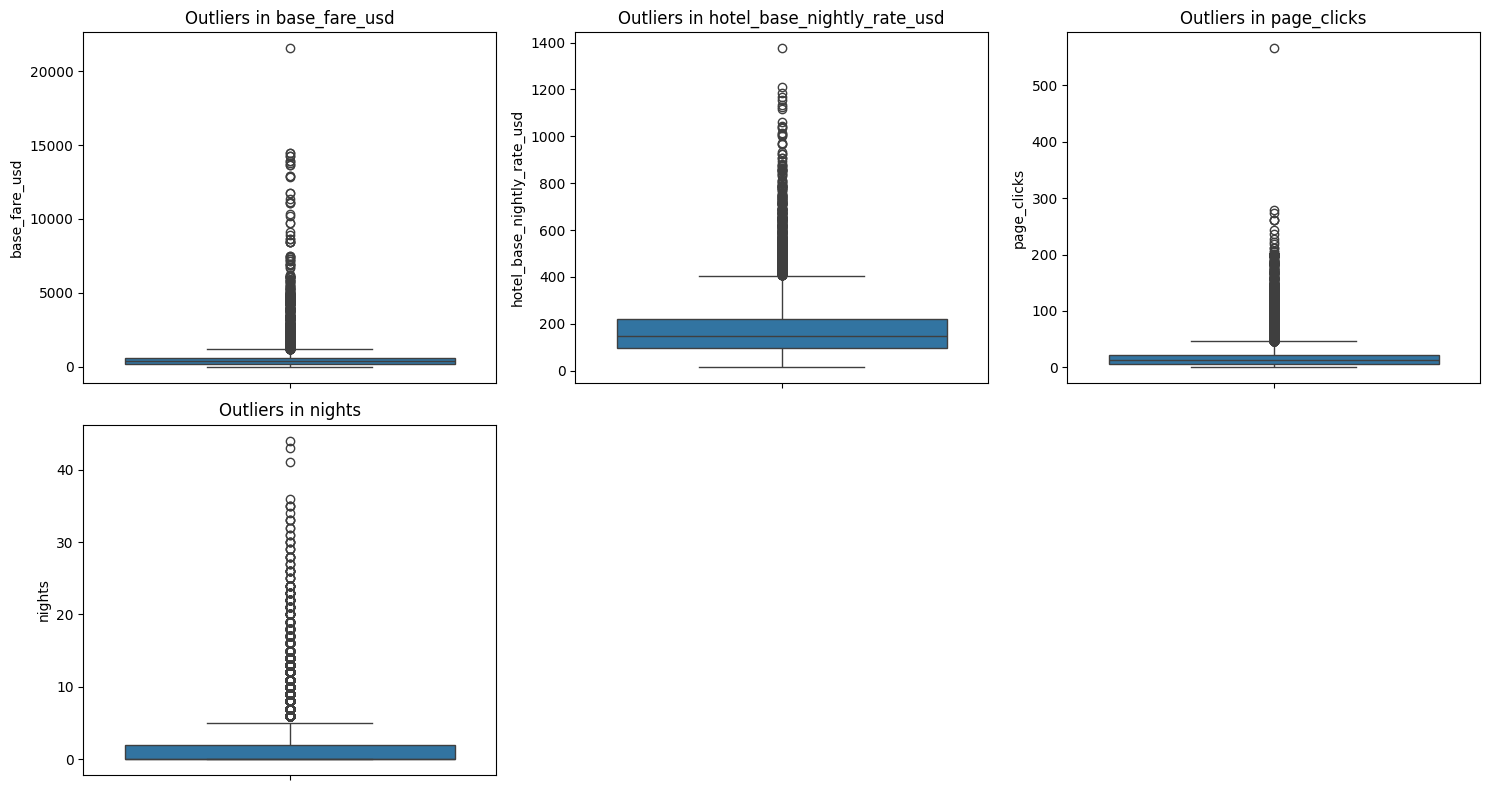

In [0]:
# 2.5 Inspect Outlier

numerical_cols_for_outliers = ['base_fare_usd', 'hotel_base_nightly_rate_usd', 'page_clicks','nights']

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols_for_outliers):
    plt.subplot(2, 3, i + 1)
     #Clip the data to better visualize the main distribution while acknowledging outliers
    #Q3 = merged_df[col].quantile(0.75)
    #IQR = merged_df[col].quantile(0.75) - merged_df[col].quantile(0.25)
    #upper_bound = Q3 + 1.5 * IQR
    
    sns.boxplot(y=filtered_sessions_pd[col].dropna()) 
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()

* flight_base_fare_usd: These outliers are the Premium Customers. They are visually distinct from the budget majority and are the precise group we should target to reward for their high spending.
* hotel_base_nightly_rate_usd: These outliers define the Luxury/High-End Hotel Segment. They should be targeted with premium hotel perks (e.g., guaranteed upgrades or lounge access) to encourage continued luxury booking.
* page_clicks: These outliers are your Researchers/Super Engagers. Their high activity makes them excellent candidates for targeted promotions to convert their research into bookings
* nights: The upper outliers define the Long-Stay Travelers (target for Free Hotel Meals).


## 3. Exploratory Data Analysis

To preserve the original cleaned dataset for reference or reuse,a working copy of the DataFrame is created.

In [0]:
# Create a working copy of the filtered DataFrame

eda_filtered_sessions_pd = filtered_sessions_pd.copy()

In [0]:
# 3.1 User Demographics Overview

demographics_summary = eda_filtered_sessions_pd.groupby('gender').agg(
    total_users=('user_id', 'nunique'),
    avg_age=('birthdate', lambda x: ((pd.Timestamp('today') - pd.to_datetime(x)).dt.days // 365).mean()),
    married_pct=('married', 'mean'),
    has_children_pct=('has_children', 'mean')
)
print("--- User Demographics Summary by Gender ---")
print(demographics_summary)
print("---Total User Count---")
print(eda_filtered_sessions_pd['user_id'].nunique())



--- User Demographics Summary by Gender ---
        total_users    avg_age  married_pct  has_children_pct
gender                                                       
F              5292  43.351885     0.448055          0.323424
M               695  42.919602     0.393454          0.346318
O                11  38.744444     0.544444          0.633333
---Total User Count---
5998


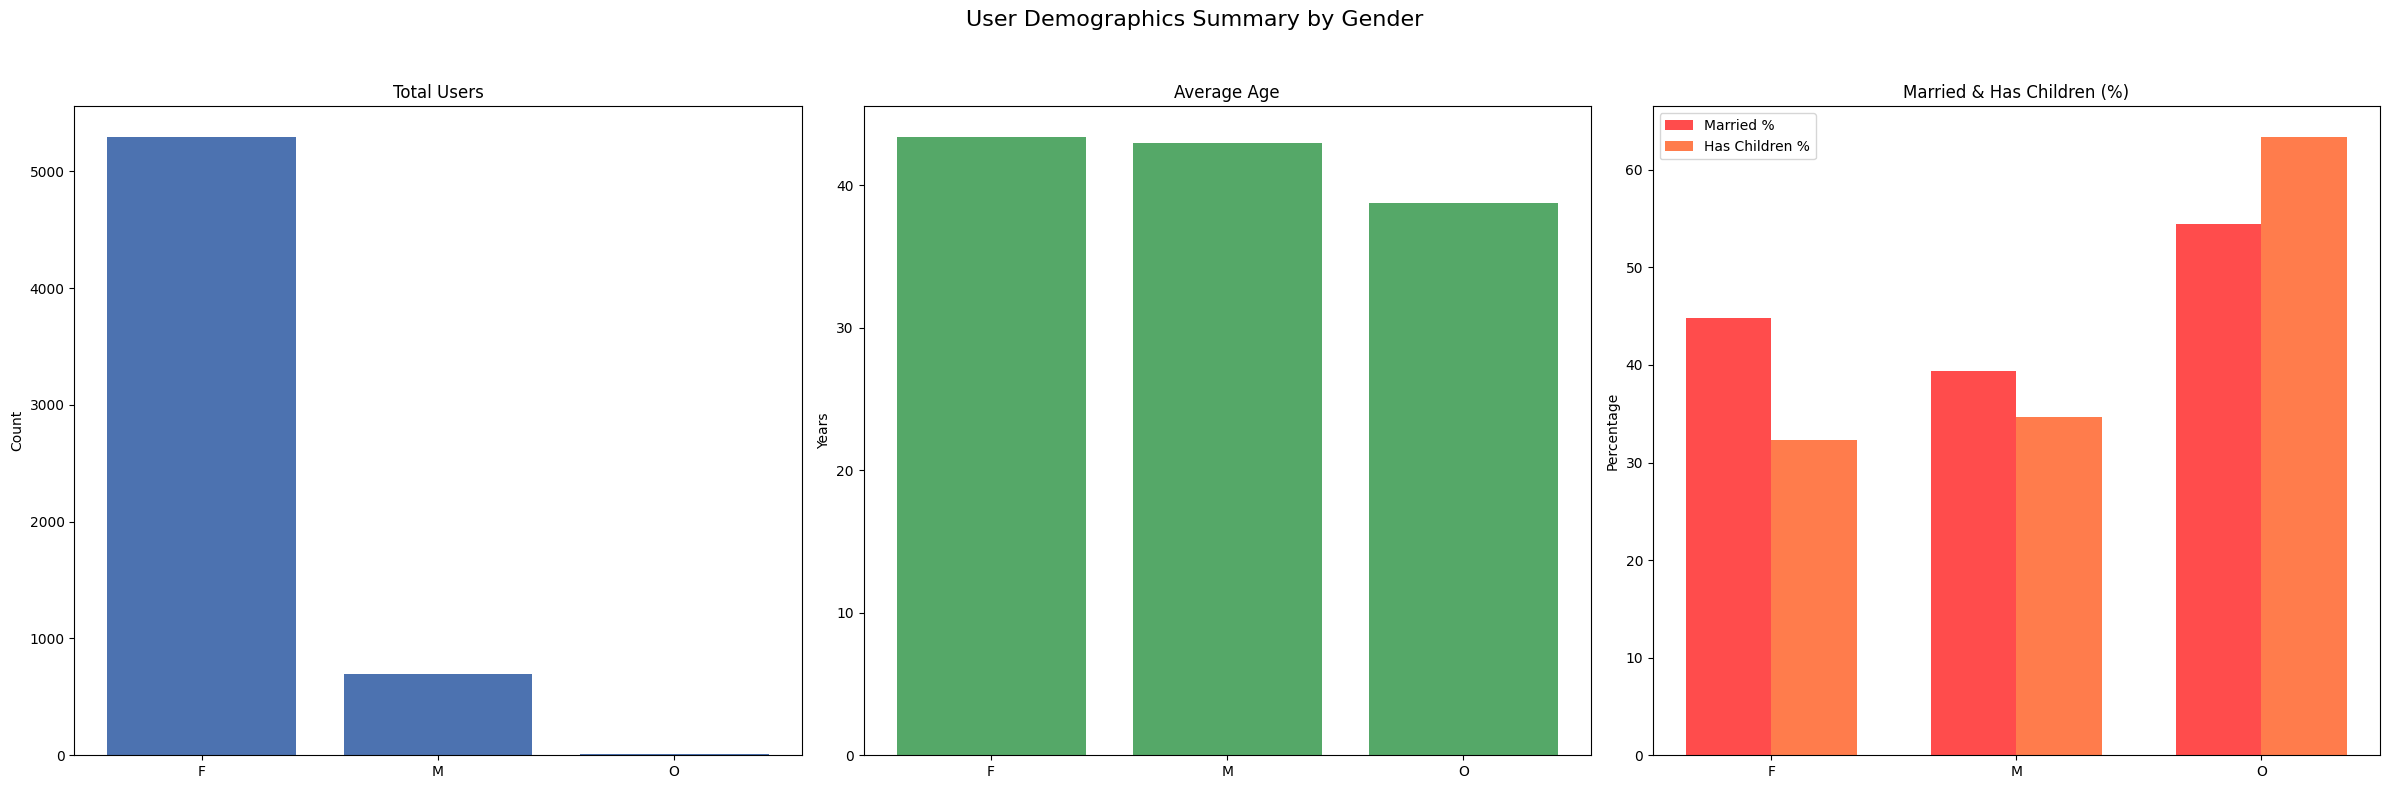

In [0]:
# Visualization for User Demographics Summary by Gender

demographics_summary_plot = demographics_summary.copy()
demographics_summary_plot['married_pct'] *= 100
demographics_summary_plot['has_children_pct'] *= 100

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('User Demographics Summary by Gender', fontsize=16)

# Total users
axes[0].bar(demographics_summary_plot.index, demographics_summary_plot['total_users'], color='#4c72b0')
axes[0].set_title('Total Users')
axes[0].set_ylabel('Count')

# Average age
axes[1].bar(demographics_summary_plot.index, demographics_summary_plot['avg_age'], color='#55a868')
axes[1].set_title('Average Age')
axes[1].set_ylabel('Years')

# Married and has children percentages (side by side bars)
bar_width = 0.35
x = np.arange(len(demographics_summary_plot.index))
axes[2].bar(x - bar_width/2, demographics_summary_plot['married_pct'], width=bar_width, label='Married %', color='red', alpha=0.7)
axes[2].bar(x + bar_width/2, demographics_summary_plot['has_children_pct'], width=bar_width, label='Has Children %', color='orangered', alpha=0.7)
axes[2].set_xticks(x)
axes[2].set_xticklabels(demographics_summary_plot.index)
axes[2].set_title('Married & Has Children (%)')
axes[2].set_ylabel('Percentage')
axes[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

1. Total Users (Size): The customer base is primarily female (F), who account for the majority of the user population. Male (M) and other (O) users represent smaller segments. The Other (O) segment is the smallest group, with 11 users, and its metrics should be reviewed with caution due to the low user count.
2. Average Age: Both the core female (F) and male (M) segments share a similar average age, approximately 43 years old. This age profile often correlates with established income and stable booking patterns. The Other (O) segment is younger, averaging near 39 years old.
3. Married and Has Children (%): The data confirms two different customer segments based on family status:
* The Other (O) segment is the most family-focused group, showing the highest percentage of users who are married (approx 54%) and who have children (approx 63%). This group is the direct target for family package deals.
* The Female (F) and Male (M) segments show marriage rates slightly higher than the percentage of users with children. This confirms the primary traveler in these segments is generally an individual or a couple without children, making them the target for individual or couples-based travel promotions.

--- Demographic Summary by Age Group ---
  age_group  total_users   married  has_children
0       <25          482  0.029262      0.286005
1     25-34          828  0.161161      0.288105
2     35-49         2951  0.431110      0.331856
3     50-64         1440  0.692165      0.400558
4       65+          297  0.776509      0.089315

--- Gender Distribution (%) by Age Group ---
gender             F          M         O
age_group                                
<25        86.099585  13.278008  0.622407
25-34      89.613527  10.265700  0.120773
35-49      87.800746  12.097594  0.101660
50-64      88.402778  11.319444  0.277778
65+        91.245791   8.754209  0.000000


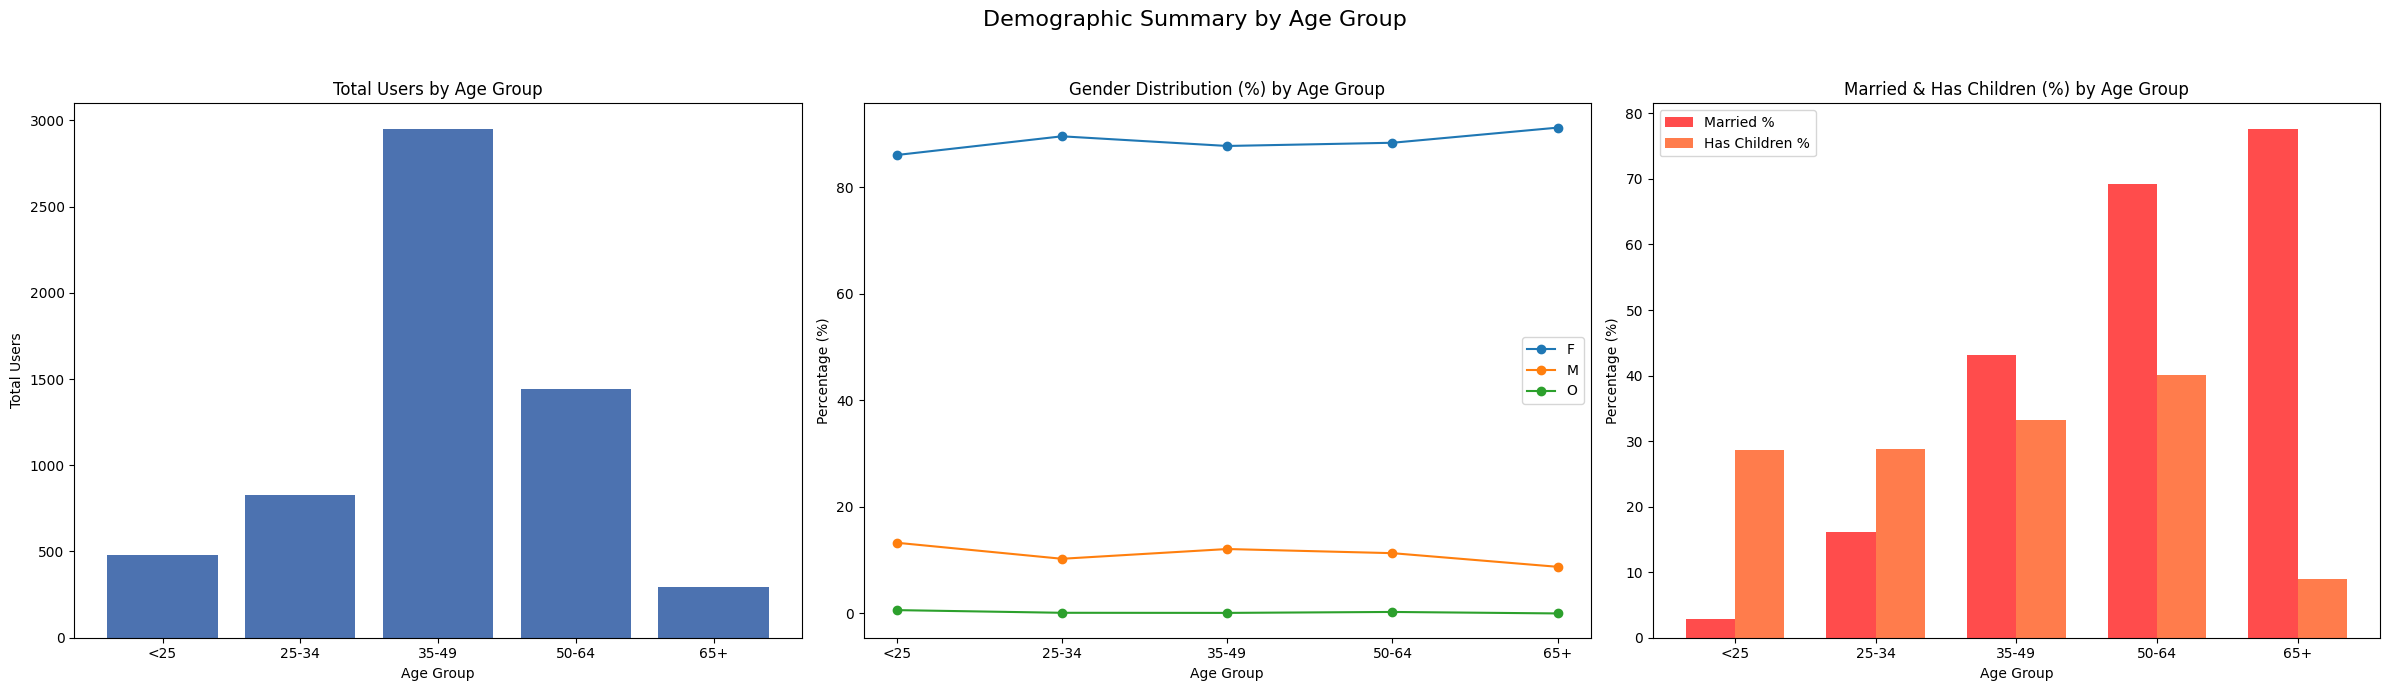

In [0]:
# 3.2 User Demographics by Age Group

# Define age groups
eda_filtered_sessions_pd['age'] = ((pd.Timestamp('today') - pd.to_datetime(eda_filtered_sessions_pd['birthdate'])).dt.days // 365)
age_bins = [0, 25, 35, 50, 65, 100]
age_labels = ['<25', '25-34', '35-49', '50-64', '65+']
eda_filtered_sessions_pd['age_group'] = pd.cut(eda_filtered_sessions_pd['age'], bins=age_bins, labels=age_labels, right=False)

# Demographic summary by age group
age_demo = eda_filtered_sessions_pd.groupby('age_group').agg(
    total_users=('user_id', 'nunique'),
    married=('married', 'mean') ,
    has_children=('has_children', 'mean') 
).reset_index()

# Gender distribution by age group
gender_dist = eda_filtered_sessions_pd.groupby(['age_group', 'gender'])['user_id'].nunique().reset_index()
gender_pivot = gender_dist.pivot(index='age_group', columns='gender', values='user_id').fillna(0)
gender_pct = gender_pivot.div(gender_pivot.sum(axis=1), axis=0) * 100

# Summary overview printout
print("--- Demographic Summary by Age Group ---")
print(age_demo)
print("\n--- Gender Distribution (%) by Age Group ---")
print(gender_pct)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Demographic Summary by Age Group', fontsize=16)

# Total users by age group
axes[0].bar(age_demo['age_group'].astype(str), age_demo['total_users'], color='#4c72b0')
axes[0].set_title('Total Users by Age Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Total Users')

# Gender distribution (%) by age group 
for gender in gender_pct.columns:
    axes[1].plot(gender_pct.index.astype(str), gender_pct[gender], marker='o', label=gender)
axes[1].set_title('Gender Distribution (%) by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Percentage (%)')
axes[1].legend()

# Married and Has Children by age group
bar_width = 0.35
x = np.arange(len(age_demo['age_group']))
axes[2].bar(x - bar_width/2, age_demo['married'] * 100, width=bar_width, label='Married %', color='red', alpha=0.7)
axes[2].bar(x + bar_width/2, age_demo['has_children'] * 100, width=bar_width, label='Has Children %', color='orangered', alpha=0.7)
axes[2].set_xticks(x)
axes[2].set_xticklabels(age_demo['age_group'].astype(str))
axes[2].set_title('Married & Has Children (%) by Age Group')
axes[2].set_xlabel('Age Group')
axes[2].set_ylabel('Percentage (%)')
axes[2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

1. The 35-49 age group is the largest user segment, followed by 50-64. 
2. The line plot reveals a strong female majority across all age groups, with the proportion of female users increasing in older groups. 
3. The married percentage rises with age, peaking in the 65+ group, but the percentage with children is highest in middle age and drops sharply for 65+, likely reflecting empty nesters.


In [0]:
# 3.3 Booking Conversion Rate by Country

booking_conversion = eda_filtered_sessions_pd.groupby('home_country').agg(
    total_sessions=('session_id', 'count'),
    flights_booked=('flight_booked', 'sum'),
    hotels_booked=('hotel_booked', 'sum')
)
booking_conversion['flight_booking_rate'] = booking_conversion['flights_booked'] / booking_conversion['total_sessions']
booking_conversion['hotel_booking_rate'] = booking_conversion['hotels_booked'] / booking_conversion['total_sessions']
print("--- Booking Conversion Rate by Country ---")
print(booking_conversion[['flight_booking_rate', 'hotel_booking_rate']].sort_values(by='flight_booking_rate', ascending=False).head(10))

--- Booking Conversion Rate by Country ---
              flight_booking_rate  hotel_booking_rate
home_country                                         
canada                   0.302739            0.314060
usa                      0.286776            0.299151


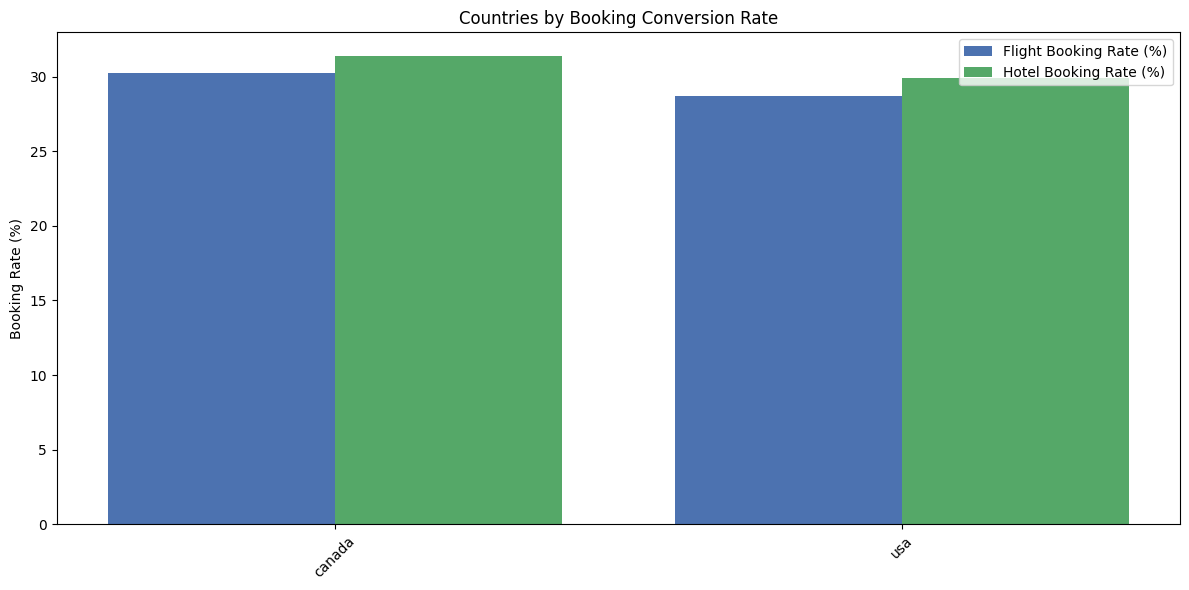

In [0]:
# Visualization: Booking Conversion Rate by Country

booking_conversion_plot = booking_conversion[['flight_booking_rate', 'hotel_booking_rate']].sort_values(by='flight_booking_rate', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.4
x = np.arange(len(booking_conversion_plot.index))

ax.bar(x - bar_width/2, booking_conversion_plot['flight_booking_rate'] * 100, width=bar_width, label='Flight Booking Rate (%)', color='#4c72b0')
ax.bar(x + bar_width/2, booking_conversion_plot['hotel_booking_rate'] * 100, width=bar_width, label='Hotel Booking Rate (%)', color='#55a868')

ax.set_xticks(x)
ax.set_xticklabels(booking_conversion_plot.index, rotation=45)
ax.set_ylabel('Booking Rate (%)')
ax.set_title('Countries by Booking Conversion Rate')
ax.legend()
plt.tight_layout()
plt.show()

1. The Canadian market converts sessions into bookings at a higher rate than the US market. Canada has a conversion rate advantage of approximately 1.5 percentage points for both flights (30.3% vs. 28.7%) and hotels (31.4% vs. 29.9%). This suggests Canadian users exhibit higher transaction intent or find the platform more appealing than their US counterparts.
2. In both countries, the Hotel Booking Rate is higher than the Flight Booking Rate (e.g., in Canada, 31.4% for hotels vs. 30.3% for flights). This confirms that users are generally more likely to convert on hotel searches. Alternatively, it suggests users may book a hotel on the platform for a trip where the flight component was book elsewhere.


session_clicks_vs_booking_boxplot.png

--- Median Page Clicks by Booking Status ---
booking_status
False     8.0
True     22.0
Name: page_clicks, dtype: float64


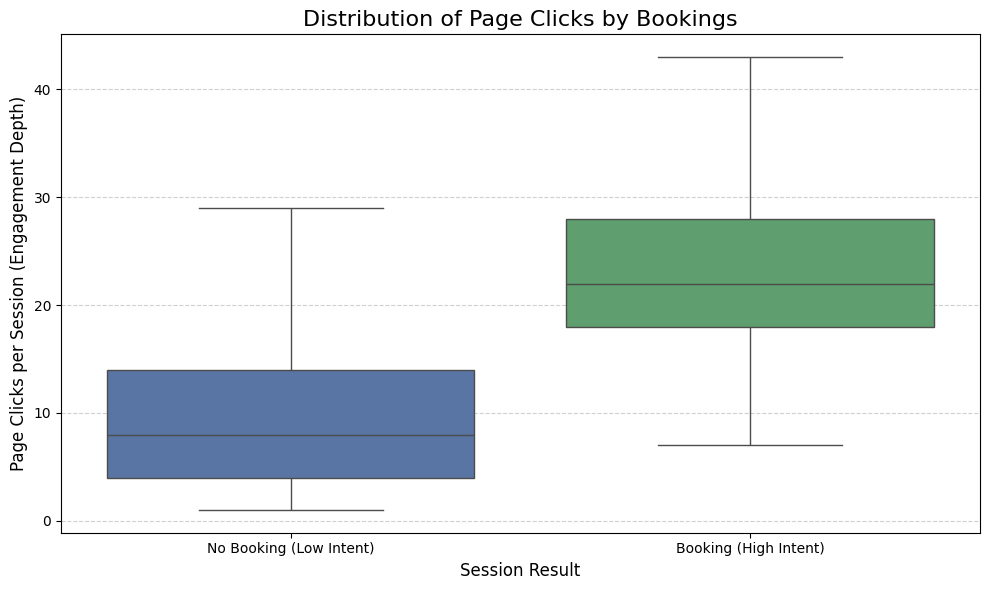

In [0]:
# 3.4 User Engagement (Page Clicks per Session) by Booking Status

# Create the 'booking_status' column
# A session is considered a booking session if either a flight or a hotel was booked.
eda_filtered_sessions_pd['booking_status'] = (
(eda_filtered_sessions_pd['flight_booked'] == 1) |
(eda_filtered_sessions_pd['hotel_booked'] == 1)
).astype(bool)

# Filter out extreme outliers in page_clicks for clearer visualization (e.g., top 1%)
# This ensures the boxplot focuses on the central trend without distortion.
clicks_upper_bound = eda_filtered_sessions_pd['page_clicks'].quantile(0.99)
plot_df = eda_filtered_sessions_pd[eda_filtered_sessions_pd['page_clicks'] < clicks_upper_bound]

# Create the Box Plot Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(
x='booking_status',
y='page_clicks',
data=plot_df,
palette=['#4c72b0', '#55a868'], # Blue for False (No Booking), Green for True (Booking)
showfliers=False # Hide individual outlier points to clean up the visualization
)

plt.title('Distribution of Page Clicks by Bookings', fontsize=16)
plt.xlabel('Session Result', fontsize=12)
plt.ylabel('Page Clicks per Session (Engagement Depth)', fontsize=12)
plt.xticks([0, 1], ['No Booking (Low Intent)', 'Booking (High Intent)'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plt.savefig('session_clicks_vs_booking_boxplot.png')
print("session_clicks_vs_booking_boxplot.png")

# Calculate Medians for Insight
median_clicks = eda_filtered_sessions_pd.groupby('booking_status')['page_clicks'].median()
print("\n--- Median Page Clicks by Booking Status ---")
print(median_clicks)

1. Sessions that resulted in a booking (True) require higher engagement, with a median of 22 clicks. Sessions that resulted in no booking (False) has a median of only 8 clicks.
2. The box plot shows that high-intent users (Booking=True) not only clicked more on average, but their entire distribution (the box) is shifted much higher than the non-booking sessions.


In [0]:
# 3.5 Popular Destinations by User Engagement (Page Clicks)

# Define how many top destinations to display
TOP_N = 10

# Aggregate Clicks and Sessions by Destination
clicks_df = eda_filtered_sessions_pd.groupby('destination').agg(
    total_clicks=('page_clicks', 'sum'),
    total_sessions=('session_id', 'nunique')
).reset_index()

# Sort and select the top destinations by total page clicks
top_clicks = clicks_df.sort_values(
    'total_clicks', ascending=False
).head(TOP_N)

print(f"\n--- 1. TOP {TOP_N} DESTINATIONS BY PAGE CLICKS (User Interest/Research) ---")
print(top_clicks[['destination', 'total_clicks']].to_string(index=False))

# 3.6 Popular Destinations by Actual Bookings (Conversion Success)

#eda_filtered_sessions_pd['booking_status'] = (
    #(eda_filtered_sessions_pd['flight_booked'] == 1) |
    #(eda_filtered_sessions_pd['hotel_booked'] == 1)
#).astype(bool)

booking_sessions = eda_filtered_sessions_pd[
    eda_filtered_sessions_pd['booking_status']
]

booking_df = booking_sessions.groupby('destination').agg(
    total_bookings=('booking_status', 'sum'),
    avg_clicks_per_booking=('page_clicks', 'mean')
).reset_index()

top_bookings = booking_df.sort_values(
    'total_bookings', ascending=False
).head(TOP_N)

print(f"\n--- 2. TOP {TOP_N} DESTINATIONS BY ACTUAL BOOKINGS (Conversion Success) ---")
print(top_bookings[['destination', 'total_bookings', 'avg_clicks_per_booking']].to_string(index=False))




--- 1. TOP 10 DESTINATIONS BY PAGE CLICKS (User Interest/Research) ---
 destination  total_clicks
    new york         57428
 los angeles         29453
     toronto         22796
     chicago         21132
     houston         16884
     phoenix         13274
philadelphia         12730
    montreal         12429
 san antonio         12360
      dallas         11372

--- 2. TOP 10 DESTINATIONS BY ACTUAL BOOKINGS (Conversion Success) ---
 destination  total_bookings  avg_clicks_per_booking
    new york            1979               29.018696
 los angeles            1039               28.347449
     toronto             753               30.273572
     chicago             714               29.596639
     houston             576               29.312500
    montreal             446               27.867713
     phoenix             438               30.305936
philadelphia             409               31.124694
 san antonio             388               31.855670
      dallas             378 

1. New York and Los Angeles are the top destinations both in terms of user interest (page clicks) and actual bookings, indicating strong market demand and conversion.
2. Toronto, Chicago, and Houston also rank highly in both metrics, showing consistent user engagement and booking success.
3. The average clicks per booking are around 28–32 for most destinations, suggesting users perform substantial research before converting.
4. Montreal stands out as the most efficient converter, with the lowest average clicks per booking among the top destinations.
5. The difference between total clicks and total bookings highlights that not all user interest leads to conversion, and most destinations require more user effort to convert.

---Average Sessions and Average Page Clicks by Age Group---
  age_group  avg_sessions  avg_page_clicks
0       <25      0.655218        15.108606
1     25-34      1.125542        16.756436
2     35-49      4.024675        18.399245
3     50-64      1.972491        17.653391
4       65+      0.408803        15.011915


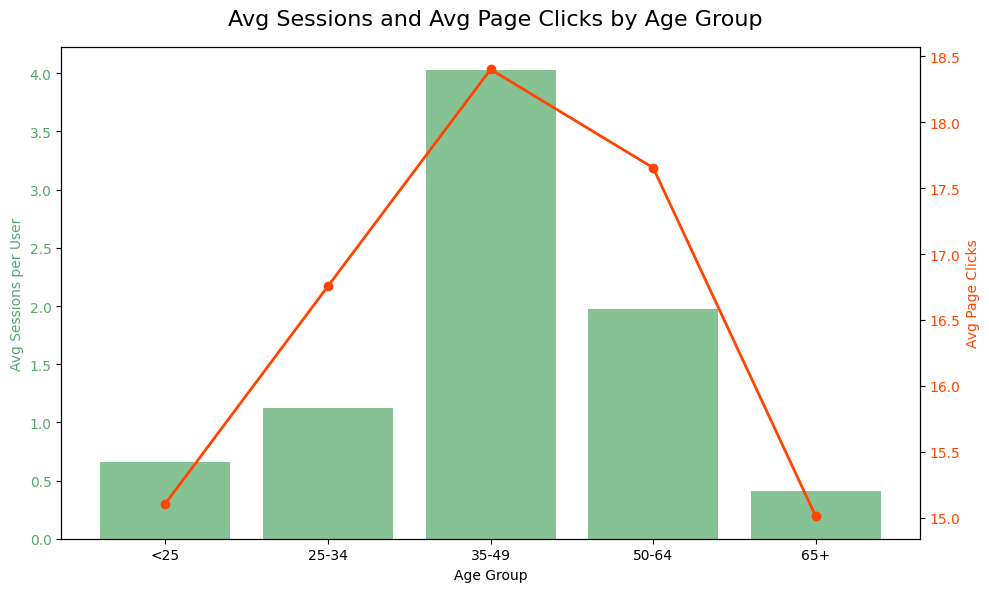

In [0]:
# 3.7 Average Sessions Per User by Age Group

sessions_per_user = eda_filtered_sessions_pd.groupby(
    ['user_id', 'age_group']
).agg(
    session_count=('session_id', 'count'),
    avg_page_clicks=('page_clicks', 'mean')
).reset_index()

age_group_stats = sessions_per_user.groupby('age_group').agg(
    avg_sessions=('session_count', 'mean'),
    avg_page_clicks=('avg_page_clicks', 'mean')
).reset_index()

print("---Average Sessions and Average Page Clicks by Age Group---")
print(age_group_stats)

# Visualization: bar for avg sessions, line for avg page clicks
fig, ax1 = plt.subplots(figsize=(10, 6))

color_sessions = '#55a868'
color_clicks = 'orangered'
ax1.bar(
    age_group_stats['age_group'].astype(str),
    age_group_stats['avg_sessions'],
    color=color_sessions,
    alpha=0.7,
    label='Avg Sessions per User'
)
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Avg Sessions per User', color=color_sessions)
ax1.tick_params(axis='y', labelcolor=color_sessions)

ax2 = ax1.twinx()
ax2.plot(
    age_group_stats['age_group'].astype(str),
    age_group_stats['avg_page_clicks'],
    color=color_clicks,
    marker='o',
    linewidth=2,
    label='Avg Page Clicks'
)
ax2.set_ylabel('Avg Page Clicks', color=color_clicks)
ax2.tick_params(axis='y', labelcolor=color_clicks)

fig.suptitle('Avg Sessions and Avg Page Clicks by Age Group', fontsize=16)
fig.tight_layout()
plt.show()

1. The 35-49 and 50-64 age groups have the highest number of sessions, indicating they are the most active users on the platform. These groups also have higher average page clicks, suggesting they interact more during each session and engage in deeper research or browsing. 
2. Younger (<25) and older (65+) users have fewer sessions and lower average page clicks, reflecting less activity and engagement per session. 
3. This insight highlights the importance of middle-aged users, who not only use the platform more frequently but also interact more during their sessions.

## 4. User Level Aggregation

We now perform user-level aggregation on the sessions table to better understand individual user behavior patterns, identify high-value customers, and support personalized marketing and product recommendations.

In [0]:
# Convert Pandas DataFrame to Spark DataFrame

spark_users_df = spark.createDataFrame(eda_filtered_sessions_pd)

In [0]:
# 4.1 Perform User Aggregations, Convert Spark Dataframe to Pandas, & Preview first rows 

user_agg_features = ( 
    spark_users_df.groupBy("user_id") .agg( 
        F.countDistinct("session_id").alias("total_sessions"), 
        F.sum("page_clicks").alias("total_page_clicks"), 
        F.avg("page_clicks").alias("avg_page_clicks"), 
        F.sum((F.col("flight_booked") & ~F.col("cancellation")).cast("int")).alias("total_flights_booked"), 
        F.sum((F.col("hotel_booked") & ~F.col("cancellation")).cast("int")).alias("total_hotels_booked"), 
        F.sum(F.col("cancellation").cast("int")).alias("total_cancellations"),
        F.sum(F.col("joint_booking").cast("int")).alias("total_joint_bookings"), 
        F.sum(F.col("trip_id").isNotNull().cast("int")).alias("trips_with_data"), 
        
        F.avg(F.when((F.col("flight_discount") & ~F.col("cancellation")), F.col("flight_discount_amount"))).alias("avg_flight_discount_usd"), 
        F.avg(F.when((F.col("hotel_discount") & ~F.col("cancellation")), F.col("hotel_discount_amount"))).alias("avg_hotel_discount_usd"), 
        F.avg(F.when((F.col("flight_booked") & ~F.col("cancellation")), F.col("base_fare_usd"))).alias("avg_flight_fare_usd"), 
        F.avg(F.when((F.col("flight_booked") & ~F.col("cancellation")), F.col("seats"))).alias("avg_seats"), 
        F.avg(F.when((F.col("flight_booked") & ~F.col("cancellation")), F.col("checked_bags"))).alias("avg_checked_bags"), 
        F.avg(F.when((F.col("hotel_booked") & ~F.col("cancellation")), F.col("hotel_base_nightly_rate_usd"))).alias("avg_hotel_price_usd"), 
        F.avg(F.when((F.col("hotel_booked") & ~F.col("cancellation")), F.col("nights"))).alias("avg_hotel_nights"), 
        F.avg(F.when((F.col("hotel_booked") & ~F.col("cancellation")),F.col("hotel_base_nightly_rate_usd") * F.col("nights"))).alias("avg_hotel_total_spend_usd"), 
        F.countDistinct(F.when((F.col("flight_booked") & ~F.col("cancellation")), F.col("trip_airline"))).alias("unique_airlines_booked"), 
        # Demographic columns
        F.max("birthdate").alias("user_birthdate"),
        F.max ("age").alias("user_age"),
        F.max("age_group").alias("user_age_group"), 
        F.max("gender").alias("user_gender"), 
        F.max("married").alias("is_married"), 
        F.max("has_children").alias("has_children"), 
        F.max("home_country").alias("user_home_country"), 
        F.max("home_city").alias("user_home_city"), 
        F.max("home_airport").alias("user_home_airport"), 
        F.max("home_airport_lat").alias("home_airport_lat"), 
        F.max("home_airport_lon").alias("home_airport_lon"), 
        F.max("sign_up_date").alias("sign_up_date") ) ) 
        

filtered_users_pd = user_agg_features.toPandas() 
filtered_users_pd.head()




,user_id,total_sessions,total_page_clicks,avg_page_clicks,total_flights_booked,total_hotels_booked,total_cancellations,total_joint_bookings,trips_with_data,avg_flight_discount_usd,avg_hotel_discount_usd,avg_flight_fare_usd,avg_seats,avg_checked_bags,avg_hotel_price_usd,avg_hotel_nights,avg_hotel_total_spend_usd,unique_airlines_booked,user_birthdate,user_age,user_age_group,user_gender,is_married,has_children,user_home_country,user_home_city,user_home_airport,home_airport_lat,home_airport_lon,sign_up_date
0,94883,8,73,9.125,2,2,0,2,2,NaN,0.10,432.045,1.5,0.5,90.0,1.5,155.0,2,1972-03-16,53,50-64,F,True,False,usa,kansas city,MCI,39.297,-94.714,2022-02-07
1,101486,8,131,16.375,1,2,0,1,2,0.075,NaN,189.910,1.0,0.0,198.5,5.0,938.0,1,1972-12-07,53,50-64,F,True,True,usa,tacoma,TCM,47.138,-122.476,2022-02-17
2,101961,8,126,15.750,5,5,0,5,5,0.150,0.10,248.532,1.0,0.4,136.0,4.8,621.8,5,1980-09-14,45,35-49,F,True,False,usa,boston,BOS,42.364,-71.005,2022-02-17
3,152583,8,149,18.625,1,1,0,1,1,0.150,0.15,367.830,1.0,2.0,213.0,3.0,639.0,1,1986-07-26,39,35-49,F,False,False,usa,colorado springs,COS,38.806,-104.700,2022-04-17
4,160754,8,86,10.750,1,1,0,1,1,NaN,NaN,93.620,1.0,1.0,214.0,3.0,642.0,1,1977-12-06,48,35-49,F,True,True,usa,new york,LGA,40.777,-73.872,2022-04-26


In [0]:
# 4.2 Inspect Data Shape

print(f"FILTERED_USERS SHAPE:")
print(f"Column: ", len(filtered_users_pd.columns))
print(f"Row: ", filtered_users_pd.shape[0])


FILTERED_USERS SHAPE:
Column:  30
Row:  5998


In [0]:
# 4.3 Inspect Missing Values

filtered_users_pd.isnull().sum().sort_values(ascending=False)

avg_hotel_discount_usd       1992
avg_flight_discount_usd      1328
avg_checked_bags              828
avg_seats                     828
avg_flight_fare_usd           828
avg_hotel_total_spend_usd     606
avg_hotel_price_usd           606
avg_hotel_nights              606
is_married                      0
user_age                        0
has_children                    0
user_home_country               0
user_home_city                  0
user_home_airport               0
home_airport_lat                0
user_gender                     0
home_airport_lon                0
user_age_group                  0
user_id                         0
user_birthdate                  0
unique_airlines_booked          0
total_sessions                  0
trips_with_data                 0
total_joint_bookings            0
total_cancellations             0
total_hotels_booked             0
total_flights_booked            0
avg_page_clicks                 0
total_page_clicks               0
sign_up_date  

Missing values mainly occur in hotel and flight booking columns, which is expected for users who browse without booking or book without receiving discounts.We proceed without imputation.



In [0]:
# 4.4 View Summary Statistics

filtered_users_pd.describe().reset_index()

,index,user_id,total_sessions,total_page_clicks,avg_page_clicks,total_flights_booked,total_hotels_booked,total_cancellations,total_joint_bookings,trips_with_data,avg_flight_discount_usd,avg_hotel_discount_usd,avg_flight_fare_usd,avg_seats,avg_checked_bags,avg_hotel_price_usd,avg_hotel_nights,avg_hotel_total_spend_usd,unique_airlines_booked,user_birthdate,user_age,home_airport_lat,home_airport_lon,sign_up_date
0,count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,4670.000000,4006.000000,5170.000000,5170.000000,5170.000000,5392.000000,5392.000000,5392.000000,5998.000000,5998,5998.000000,5998.000000,5998.000000,5998
1,mean,545440.695565,8.186729,143.776092,17.561232,2.268256,2.368123,0.101367,2.072357,2.766756,0.140352,0.111669,527.559712,1.212580,0.596670,178.028558,4.755865,840.810935,2.070357,1982-03-13 01:45:09.303100992,43.255418,38.439744,-94.176286,2023-01-20 02:26:12.524174592
2,min,23557.000000,5.000000,33.000000,4.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.050000,5.350000,1.000000,0.000000,24.000000,0.000000,0.000000,0.000000,1935-05-10 00:00:00,18.000000,21.316000,-157.927000,2021-07-22 00:00:00
3,25%,517152.000000,8.000000,102.000000,12.444444,1.000000,1.000000,0.000000,1.000000,2.000000,0.100000,0.075000,280.729375,1.000000,0.250000,123.666667,3.000000,414.000000,1.000000,1974-09-26 06:00:00,36.000000,33.818000,-112.383000,2023-01-08 00:00:00
4,50%,540542.000000,8.000000,127.000000,15.612500,2.000000,2.000000,0.000000,2.000000,3.000000,0.125000,0.100000,391.897500,1.000000,0.500000,163.000000,4.000000,645.000000,2.000000,1981-10-20 12:00:00,44.000000,39.103000,-90.035000,2023-01-19 00:00:00
5,75%,574146.000000,8.000000,161.000000,19.625000,3.000000,3.000000,0.000000,3.000000,4.000000,0.175000,0.150000,562.233125,1.333333,1.000000,212.333333,6.000000,1016.541667,3.000000,1989-04-07 18:00:00,51.000000,42.266500,-79.370000,2023-02-05 00:00:00
6,max,844489.000000,12.000000,873.000000,109.125000,8.000000,8.000000,2.000000,9.000000,9.000000,0.550000,0.450000,14280.380000,6.000000,5.000000,1063.000000,31.000000,9015.000000,7.000000,2006-12-28 00:00:00,90.000000,61.251000,-63.499000,2023-05-18 00:00:00
7,std,64924.749760,0.479853,72.202223,8.730814,1.506662,1.454965,0.310015,1.472136,1.565250,0.071364,0.054403,696.712409,0.436115,0.503085,84.396808,2.948419,718.920608,1.347947,NaN,12.058599,6.189297,18.071233,NaN



1. User Activity: Most users have 8 sessions (median), with a minimum of 5 and a maximum of 12. The average number of page clicks per user is 144, but some users have up to 873 clicks, indicating a few highly active users.
2. Bookings: Median flights and hotels booked per user are 2, with some users booking up to 8 flights/hotels. Most users do not cancel (median cancellations = 0), but a few have up to 2 cancellations.
3. Trips: Users typically have 3 trips with data, but some have up to 9.
4. Discounts: Average flight and hotel discounts are modest (mean ~0.14 and ~0.11), with some users receiving much higher discounts.
5. Spending: The average flight fare is $528, but some users spend up to $14,280. Hotel nightly rates average $178, with a maximum of $1,063.
6. Hotel Stays: Median hotel nights per user is 4, with some users staying up to 31 nights.
7. Airlines: Most users book with 2 airlines, but some use up to 7.

Insight:  
Most users are moderate in their activity and spending, but there are valuable outliers with high engagement and large purchases. Targeted marketing and loyalty programs for these high-value users could increase revenue. The low cancellation rate suggests strong customer satisfaction and reliability in the booking process.

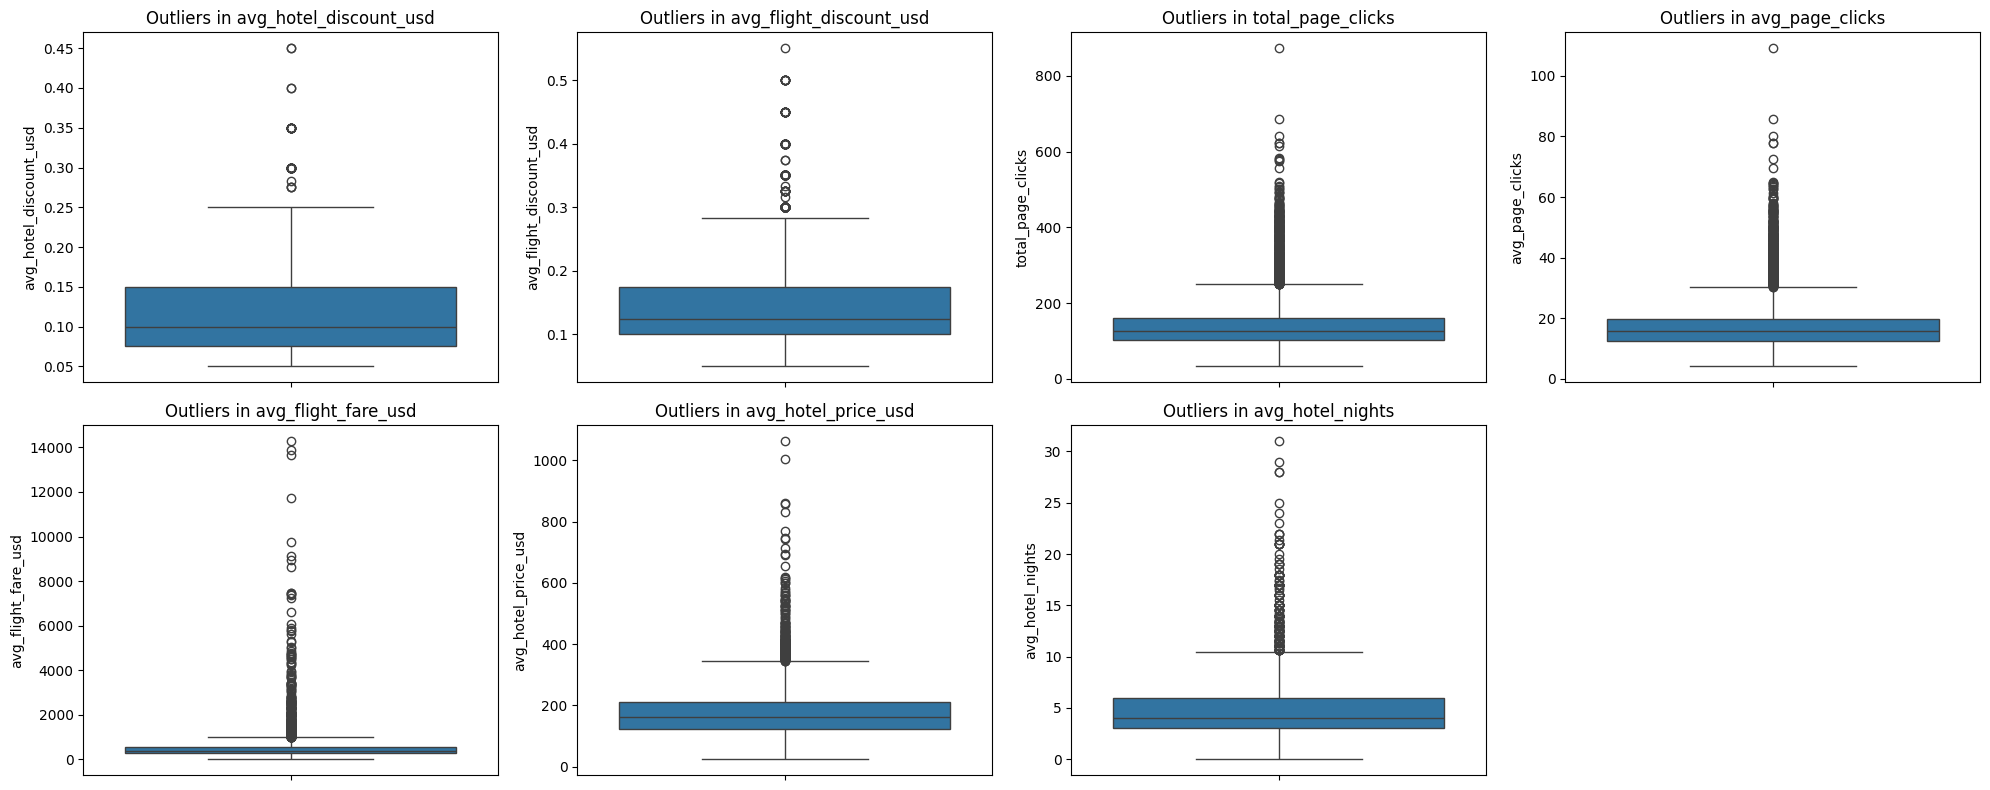

In [0]:
# 4.5 Inspect Outliers

numerical_cols = [
    'avg_hotel_discount_usd',
    'avg_flight_discount_usd',
    'total_page_clicks',
    'avg_page_clicks',
    'avg_flight_fare_usd',
    'avg_hotel_price_usd',
    'avg_hotel_nights'
]

# Set up the main figure and subplots (2 rows, 3 columns)
plt.figure(figsize=(20, 8)) 

# Loop through the columns and create a boxplot for each one
for i, col in enumerate(numerical_cols):
    # This correctly selects the i+1 position in the 2x3 grid
    plt.subplot(2, 4, i + 1) 
    sns.boxplot(y=filtered_users_pd[col].dropna()) 
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

1. The core customer base is budget-to-mid-range for both flights and hotels, typically booking stays of 3 to 4 nights, while receiving very low discounts. However, a small segment of High-Value Outliers exists across all metrics: they receive the highest discounts, drive the largest revenue through flight fares up to $14,000, and account for long-stay bookings (up to 31 nights). These high-value outliers are essential to revenue but represent a distinct segment that must be targeted separately.

## 5. Exploratory Data Analysis On User Aggregated Level

In [0]:
# Create a working copy of the filtered_users_pd DataFrame

eda_filtered_users_pd = filtered_users_pd.copy() 

--- Correlation Matrix ---
                      total_flights_booked  total_hotels_booked  total_page_clicks  total_cancellations  total_sessions
total_flights_booked              1.000000             0.838542           0.332223             0.063510        0.045334
total_hotels_booked               0.838542             1.000000           0.310162             0.016703        0.047936
total_page_clicks                 0.332223             0.310162           1.000000             0.743611        0.121294
total_cancellations               0.063510             0.016703           0.743611             1.000000        0.042000
total_sessions                    0.045334             0.047936           0.121294             0.042000        1.000000
correlation_heatmap_from_merged.png


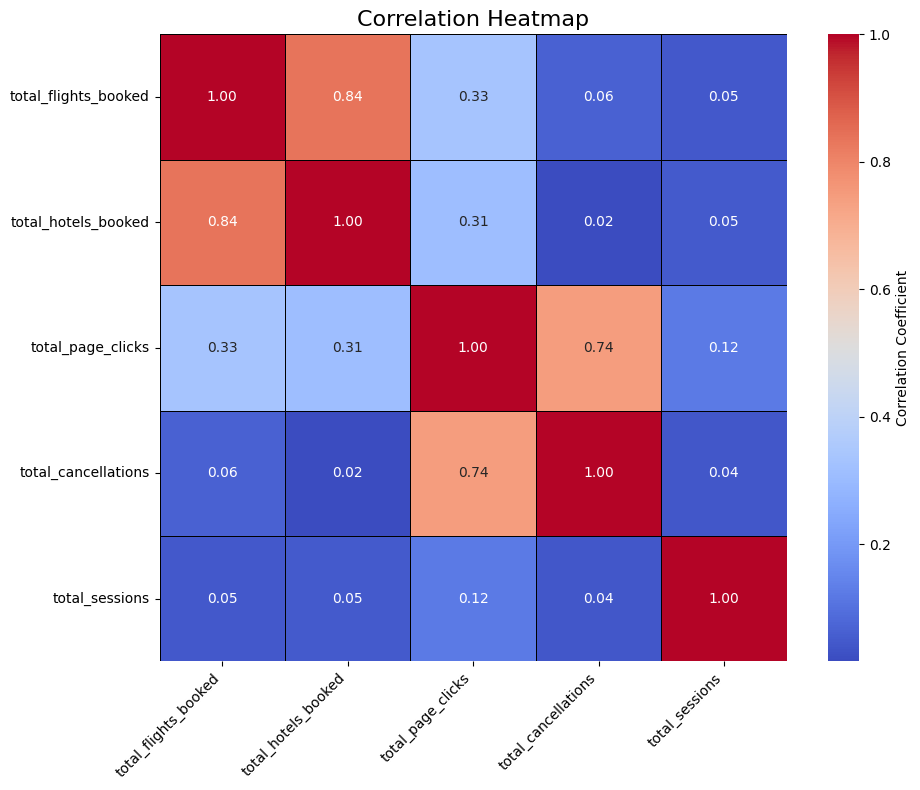

In [0]:
# 5.1 Correlation Analysis: Feature Relationships

# Define the key features for segmentation analysis
correlation_features = [
    'total_flights_booked',          # Flight Booking Frequency
    'total_hotels_booked',           # Hotel Booking Frequency
    'total_page_clicks',             # Engagement/Activity
    'total_cancellations',           # Risk/Friction
    'total_sessions'                 # Overall Engagement (Context)
]

# Calculate the correlation matrix 
correlation_matrix = eda_filtered_users_pd[correlation_features].corr()

print("--- Correlation Matrix ---")
print(correlation_matrix.to_string())

# 3. Create the visualization (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=.5,
    linecolor='black',
    square=True
)

# Adjust labels for readability
plt.title('Correlation Heatmap', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
plt.savefig('correlation_heatmap_from_merged.png')
print("correlation_heatmap_from_merged.png")

1. Strong Relationship Between Booking Types (The Transactional Core)
* Correlation: total_flights_booked and total_hotels_booked have a very strong correlation of 0.8385.
* Insight: This is the strongest positive relationship in the matrix. It confirms that customers who book a flight are highly likely to also book a hotel, and vice-versa (they are booking complete trip packages).
2. The Link Between Browsing and Cancellation (The Risk Factor)
* Correlation: total_page_clicks and total_cancellations have a strong positive correlation of 0.7436.
* Insight: This is the most crucial finding for risk management. It suggests that high-engagement users (those who browse extensively and click many pages) are also the ones most likely to cancel their bookings. This implies that the "Deep Researcher / Intense Planner"'s deep research might lead to information overload, second-guessing, or booking multiple options to evaluate later.
3. Weakness of Sessions as a Segmenting Feature
* Correlation: total_sessions has very low correlations across the board (all values under 0.13).
* Insight: Total_sessions is highly uniform in the filtered dataset. It has little predictive relationship with actual bookings, clicks, or cancellations.
4. Cancellation is Tied to Clicks, Not Bookings
* Correlation:
 * total_cancellations vs. total_page_clicks: 0.7436 (Strong)
 * total_cancellations vs. total_flights_booked: 0.0635 (Weak)
 * total_cancellations vs. total_hotels_booked: 0.0167 (Very Weak)
* Insight: Cancellations are not simply a function of how much a user books; they are overwhelmingly correlated with how much a user browses. The act of researching intensely might be the main driver of the subsequent decision to cancel.

In [0]:
# 5.2 Correlation Analysis: Page Clicks vs. Booking Frequency

# Define the features to analyze
correlation_features = [
    'total_page_clicks',
    'total_flights_booked',
    'total_hotels_booked',
    'avg_hotel_total_spend_usd'
]

# Calculate the correlation matrix
correlation_matrix = eda_filtered_users_pd[correlation_features].corr()

print("--- Correlation: Page Clicks vs. Booking Frequency ---")
print(correlation_matrix.to_string())

--- Correlation: Page Clicks vs. Booking Frequency ---
                           total_page_clicks  total_flights_booked  total_hotels_booked  avg_hotel_total_spend_usd
total_page_clicks                   1.000000              0.332223             0.310162                  -0.031327
total_flights_booked                0.332223              1.000000             0.838542                  -0.232336
total_hotels_booked                 0.310162              0.838542             1.000000                  -0.099668
avg_hotel_total_spend_usd          -0.031327             -0.232336            -0.099668                   1.000000


1. Buying is Tied Together: Customers who book a flight are almost always booking a hotel, too. The link between flight and hotel purchases is very strong (0.84).
2. Browsing is Inefficient: A customer clicking many pages does not mean they will buy more often. The link between clicks and booking is weak, just around 0.33.
3. Customers are Heavy Evaluators: This weak link shows that high-click users spend most of their time comparing and researching, not necessarily buying.

--- User Segmentation by Parental Status ---
Solo Travels: 4040 users (67.4%)
Family: 1958 users (32.6%)


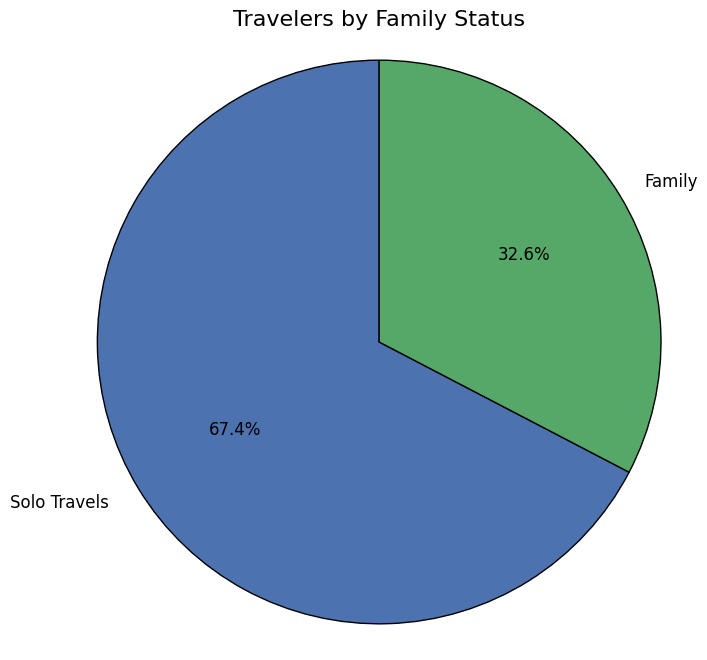

In [0]:
# 5.3 User Segmentation by Parental Status 

# 1. Calculate the counts for the two segments
segment_counts = filtered_users_pd['has_children'].value_counts()

# Set labels based on the calculated counts
labels = ['Solo Travels ', 'Family'] 
sizes = segment_counts.values
colors = ['#4c72b0', '#55a868'] 

# Output user segmentation summary by parental status
print("--- User Segmentation by Parental Status ---")
for label, count, pct in zip(labels, segment_counts.values, segment_counts.values / segment_counts.values.sum() * 100):
    print(f"{label.strip()}: {count} users ({pct:.1f}%)")


plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', # Display percentage
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

plt.title('Travelers by Family Status', fontsize=16)
plt.axis('equal') # Ensures the pie chart is a circle.
plt.show()




1. Majority Without Children: 67.4% of users do not have children, while 32.6% do. This indicates that the core customer base is predominantly singles or couples without children.


--- Average Bookings by Parental Status ---
   has_children  total_flights_booked  total_hotels_booked
0         False              2.355198             2.442327
1          True              2.088866             2.215015
--- Parental Status ---
  Parental Status  User Count  Percentage
0   Solo Travels         4040   67.355785
1          Family        1958   32.644215


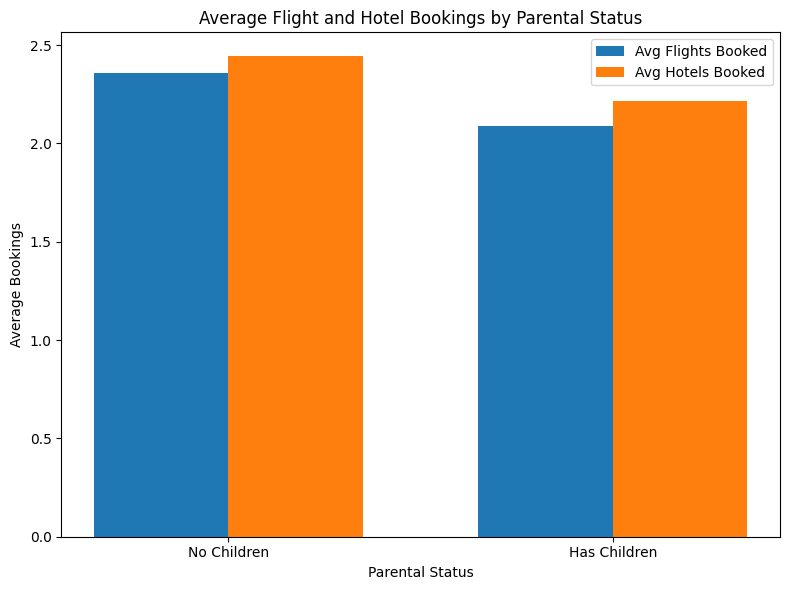

In [0]:
# 5.4 Bookings by Parental Status

booking_features = ['total_flights_booked', 'total_hotels_booked']
parent_col = 'has_children'

# Calculate mean bookings by parental status
booking_means = eda_filtered_users_pd.groupby(parent_col)[booking_features].mean().reset_index()

print("--- Average Bookings by Parental Status ---")
print(booking_means)

# Summary overview: count and percentage by parental status
segment_counts = eda_filtered_users_pd[parent_col].value_counts()
summary = pd.DataFrame({
    'Parental Status': labels,
    'User Count': segment_counts.values,
    'Percentage': segment_counts.values / segment_counts.values.sum() * 100
})

print("--- Parental Status ---")
print(summary)

# Bar plot: Average bookings by parental status
labels = ['No Children', 'Has Children']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(
    x - width/2,
    booking_means[booking_features[0]],
    width,
    label='Avg Flights Booked'
)
plt.bar(
    x + width/2,
    booking_means[booking_features[1]],
    width,
    label='Avg Hotels Booked'
)
plt.xlabel('Parental Status')
plt.ylabel('Average Bookings')
plt.title('Average Flight and Hotel Bookings by Parental Status')
plt.xticks(x, labels)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


1. Users without children book slightly more flights and hotels on average than users with children. This suggests that users without children may travel more frequently or have greater flexibility in their travel plans, while users with children might travel less often or be more selective in their bookings. 


--- Average Bookings by Gender ---
  user_gender  total_flights_booked  total_hotels_booked
0           F              2.267952             2.372071
1           M              2.270504             2.338129
2           O              2.272727             2.363636


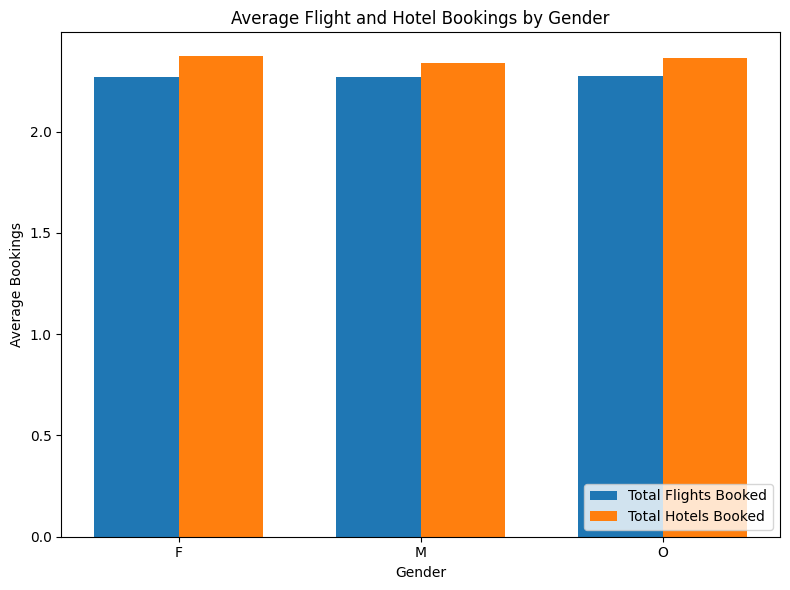

In [0]:
# 5.5 Bookings by Gender

booking_features = ['total_flights_booked', 'total_hotels_booked']
gender_col = 'user_gender'

booking_means = eda_filtered_users_pd.groupby(gender_col)[booking_features].mean().reset_index()

# Output summary overview of average bookings by gender
print("--- Average Bookings by Gender ---")
print(booking_means)

x = np.arange(len(booking_means[gender_col]))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(8, 6))
plt.bar(
    x - width/2,
    booking_means[booking_features[0]],
    width,
    label=booking_features[0].replace('_', ' ').title()
)
plt.bar(
    x + width/2,
    booking_means[booking_features[1]],
    width,
    label=booking_features[1].replace('_', ' ').title()
)

plt.xlabel('Gender')
plt.ylabel('Average Bookings')
plt.title('Average Flight and Hotel Bookings by Gender')
plt.xticks(x, booking_means[gender_col])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



* The average flight and hotel bookings are nearly identical across all gender groups, with only minimal differences. This suggests that gender does not influence individual booking behavior in our case.


In [0]:
# 5.6 Average Spend by Age Group

eda_filtered_users_pd['age_group'] = pd.cut(
    ((pd.Timestamp('today') - pd.to_datetime(eda_filtered_users_pd['user_birthdate'])).dt.days // 365),
    bins=[0, 25, 35, 50, 65, 100],
    labels=['<25', '25-34', '35-49', '50-64', '65+']
)
result = eda_filtered_users_pd.groupby('age_group')[
    ['avg_flight_fare_usd', 'avg_hotel_total_spend_usd']
].mean().reset_index()

print("--- Average Spend by Age Group ---")
print(result)

--- Average Spend by Age Group ---
  age_group  avg_flight_fare_usd  avg_hotel_total_spend_usd
0       <25           760.515262                1196.647417
1     25-34           562.031382                 938.086657
2     35-49           493.848318                 756.712208
3     50-64           502.590046                 813.368826
4       65+           921.868546                1326.649408


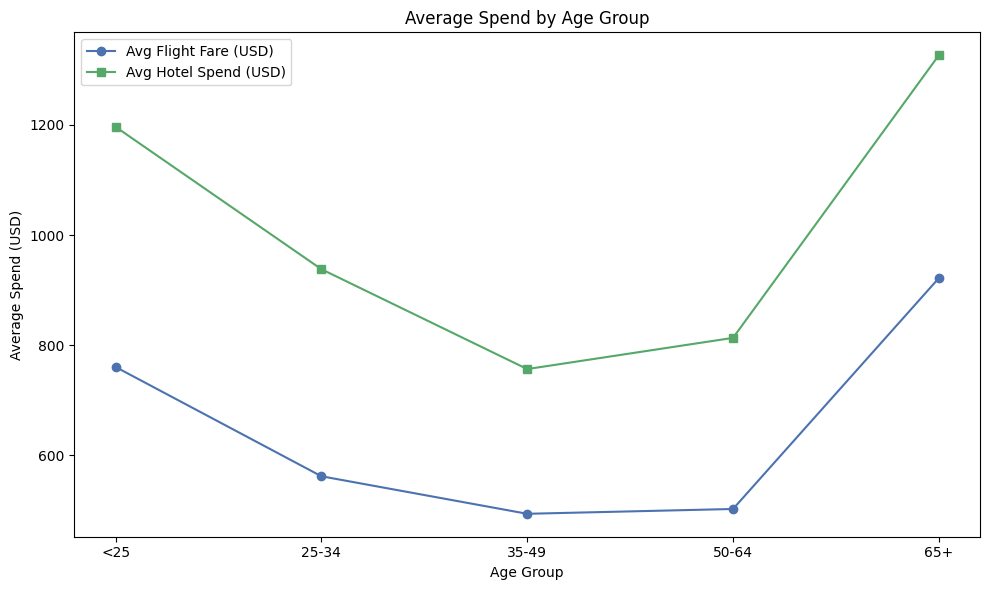

In [0]:
# Visualization: Average Spend by Age Group

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(result['age_group'].astype(str), result['avg_flight_fare_usd'], marker='o', label='Avg Flight Fare (USD)', color='#4c72b0')
ax.plot(result['age_group'].astype(str), result['avg_hotel_total_spend_usd'], marker='s', label='Avg Hotel Spend (USD)', color='#55a868')
ax.set_xlabel('Age Group')
ax.set_ylabel('Average Spend (USD)')
ax.set_title('Average Spend by Age Group')
ax.legend()
plt.tight_layout()
plt.show()

1. U-shaped spending pattern: Both the youngest (<25) and oldest (65+) groups spend the most, while middle-aged groups (25–49, 50–64) spend less.
2. Youth vs seniors: Younger travelers may spend more impulsively, while seniors prioritize comfort and quality.
3. Middle-aged travelers: Appear more cost-efficient, balancing family needs and budgets.



--- No of Users per Spend Segments ---


spend_segment
Mid-Range    2928
Premium      1802
Budget       1268
Name: count, dtype: int64

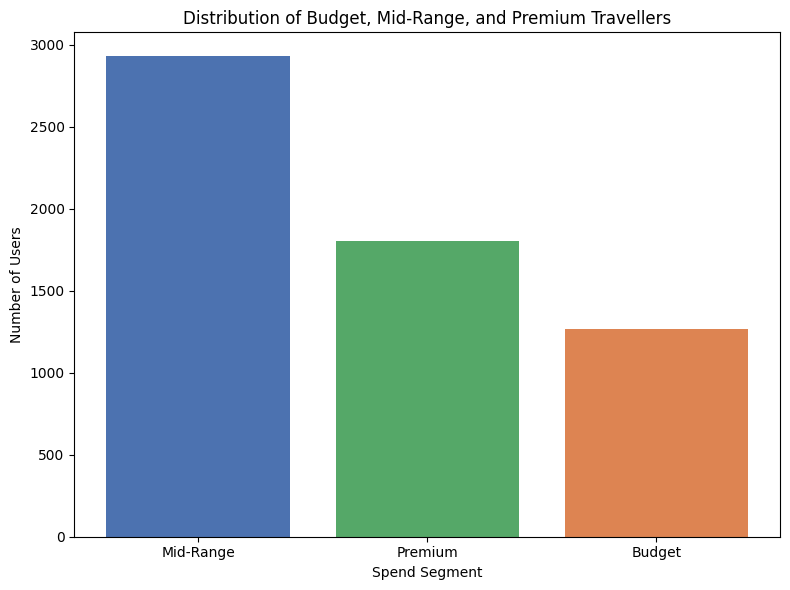

In [0]:
# 5.7 Number of Users per Spend Segments 

# Define spend thresholds for segmentation
budget_threshold = 500
mid_range_threshold = 1000

def classify_traveller(row):
    if row['avg_flight_fare_usd'] <= budget_threshold and row['avg_hotel_total_spend_usd'] <= budget_threshold:
        return 'Budget'
    elif (row['avg_flight_fare_usd'] <= mid_range_threshold and row['avg_flight_fare_usd'] > budget_threshold) or \
         (row['avg_hotel_total_spend_usd'] <= mid_range_threshold and row['avg_hotel_total_spend_usd'] > budget_threshold):
        return 'Mid-Range'
    else:
        return 'Premium'

eda_filtered_users_pd['spend_segment'] = eda_filtered_users_pd.apply(classify_traveller, axis=1)

segment_counts = eda_filtered_users_pd['spend_segment'].value_counts()
print("--- No of Users per Spend Segments ---")
display(segment_counts)

# Visualize spend segments
plt.figure(figsize=(8, 6))
plt.bar(segment_counts.index, segment_counts.values, color=['#4c72b0', '#55a868', '#dd8452'])
plt.xlabel('Spend Segment')
plt.ylabel('Number of Users')
plt.title('Distribution of Budget, Mid-Range, and Premium Travellers')
plt.tight_layout()
plt.show()

Most customers spend in the mid-range, but there are also a lot of premium spenders. A smaller group is more budget-focused.

This helps explain the differences we saw by age:

Business travelers, who are often middle-aged, tend to keep costs lower, so they fall into the budget or mid-range categories.

Leisure travelers, especially younger and older users, spend more per trip, which puts them into the premium category.

--- Traveller Type ---
  Traveller Type  User Count  Percentage
0        Leisure        4029   67.172391
1         Family        1956   32.610870
2       Business          13    0.216739


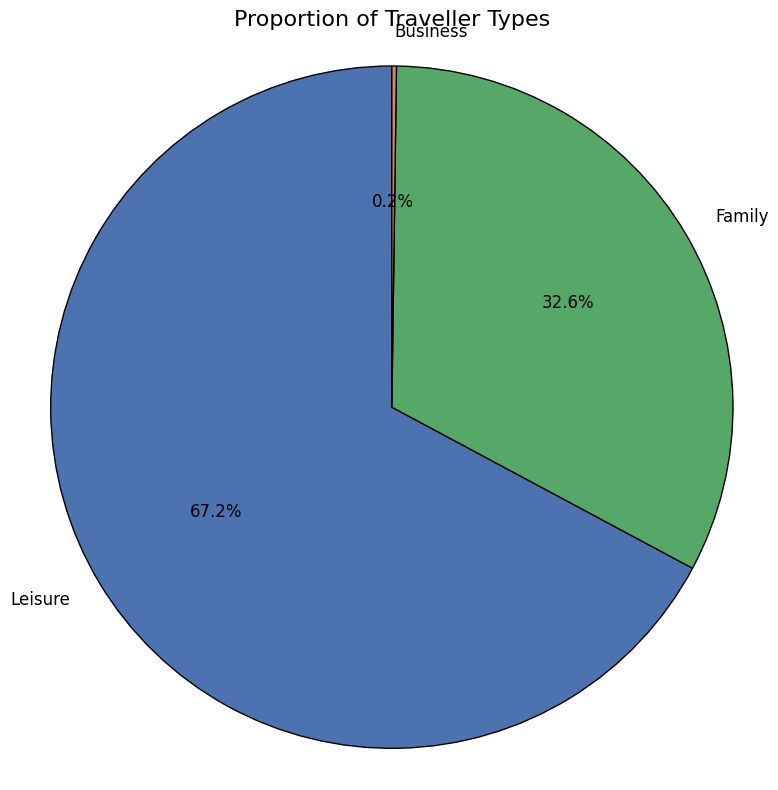

In [0]:
# 5.8 User Segmentation by Traveller Type 

# Use departure_time in sessions table to determine weekday travel
filtered_sessions_pd['travel_weekday'] = pd.to_datetime(filtered_sessions_pd['departure_time']).dt.weekday
weekday_travel = filtered_sessions_pd[filtered_sessions_pd['travel_weekday'] < 6]

weekday_counts = weekday_travel.groupby('user_id').size()
total_counts = filtered_sessions_pd.groupby('user_id').size()
weekday_travel_ratio = (weekday_counts / total_counts).fillna(0)

eda_filtered_users_pd['weekday_travel_ratio'] = eda_filtered_users_pd['user_id'].map(weekday_travel_ratio)

# Enhanced traveller type logic: Business travellers are those who aged 30–55, have joint-bookings, travel light and alone and on weekdays, and have short stays .

def classify_traveller(row):
    if (
        #row['total_flights_booked'] >= 2 or
        #row['total_hotels_booked'] >= 2 and
        30 <= row['user_age'] <= 55 and
        row['total_joint_bookings'] == row['total_flights_booked'] == row['total_hotels_booked'] and 
        row['avg_seats'] <= 1 and
        row['avg_checked_bags'] <= 1 and
        row['avg_hotel_nights'] <= 3 and
        row['weekday_travel_ratio'] is not None and
        row['weekday_travel_ratio'] > 0.6
    ):
        return 'Business'
    elif row['has_children'] == True:
        return 'Family'
    else:
        return 'Leisure'
    
eda_filtered_users_pd['traveller_type'] = eda_filtered_users_pd.apply(classify_traveller, axis=1)

traveller_counts = eda_filtered_users_pd['traveller_type'].value_counts()
traveller_pct = traveller_counts / traveller_counts.sum() * 100

# Summary overview DataFrame
summary = pd.DataFrame({
    'Traveller Type': traveller_counts.index,
    'User Count': traveller_counts.values,
    'Percentage': traveller_pct.values
})
print("--- Traveller Type ---")
print(summary) 

# Visualize traveller types with a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    traveller_counts.values,
    labels=traveller_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4c72b0', '#55a868', '#dd8452', '#c44e52'],
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)
plt.title('Proportion of Traveller Types', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

--- Average Bookings by Travel Type ---
  traveller_type  total_flights_booked  total_hotels_booked
0       Business              5.384615             5.384615
1         Family              2.085378             2.211656
2        Leisure              2.346984             2.434351


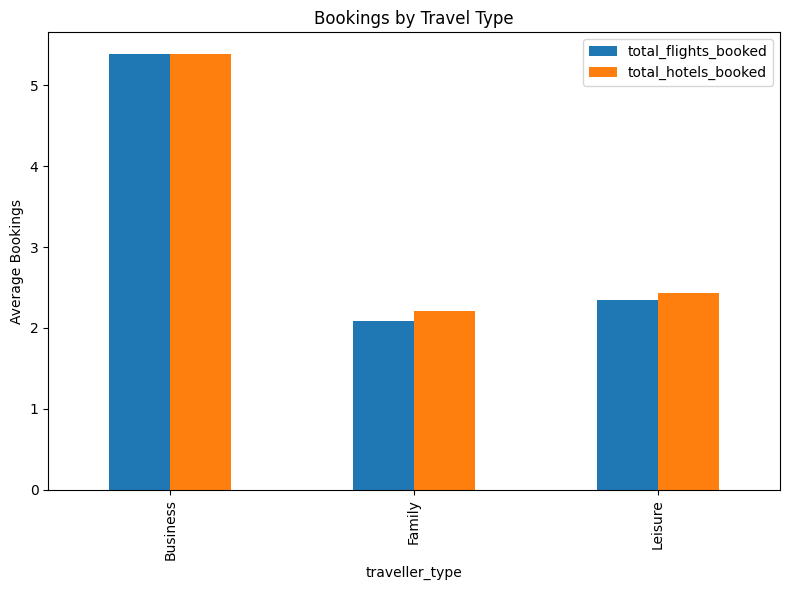

In [0]:
# 5.9 Bookings by Traveller Type

segmentation_col = 'traveller_type'  
booking_features = ['total_flights_booked', 'total_hotels_booked']

booking_means = eda_filtered_users_pd.groupby(segmentation_col)[booking_features].mean().reset_index()

print("--- Average Bookings by Travel Type ---")
print(booking_means)

booking_means.plot(
    x=segmentation_col,
    kind='bar',
    figsize=(8, 6)
)
plt.ylabel('Average Bookings')
plt.title('Bookings by Travel Type')
plt.tight_layout()
plt.show()

Business travellers have the highest average number of flight and hotel bookings compared to family and leisure travellers. This is logical, as business travellers typically travel more frequently for work, resulting in more bookings per user, even though they represent the smallest portion of the user base. 


--- Cancellations by Travel Type ---
  traveller_type      mean  sum
0       Business  0.000000    0
1         Family  0.103272  202
2        Leisure  0.100769  406


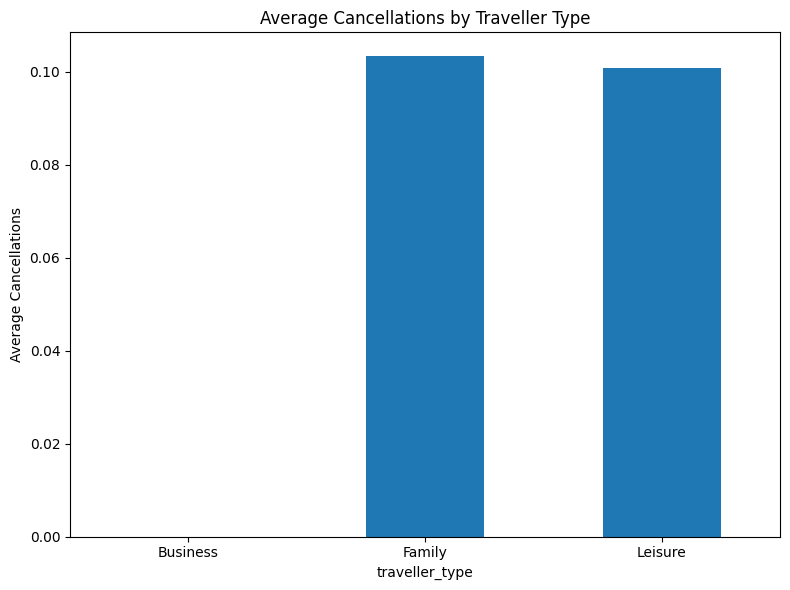

In [0]:
# 5.10 Cancellations by Traveller Type

# Calculate mean and total cancellations by traveller type
cancellation_stats = eda_filtered_users_pd.groupby('traveller_type')[
    'total_cancellations'
].agg(['mean', 'sum']).reset_index()

print("--- Cancellations by Travel Type ---")
print(cancellation_stats)

# Plot mean cancellations by traveller type
cancellation_stats.plot(
    x='traveller_type',
    y='mean',
    kind='bar',
    figsize=(8, 6),
    legend=False
)
plt.ylabel('Average Cancellations')
plt.title('Average Cancellations by Traveller Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

1. Family and leisure travellers have a noticeably higher average cancellation rate per user compared to business travellers. 
2. While business travellers have an average cancellation rate of 0, both family and leisure travellers cancel at rates just above 0.10. 
3. This suggests that family and leisure travel plans are more likely to change or be disrupted, possibly due to personal or external factors.

In [0]:
# Define the file path.
OUTPUT_FILENAME = 'traveltide_final_features.csv'

# Save the DataFrame to CSV without including the index column.
# This operation will fail with a NameError if eda_filtered_users_pd is undefined.
eda_filtered_users_pd.to_csv(OUTPUT_FILENAME, index=False)

print(f"Success! DataFrame saved as '{OUTPUT_FILENAME}' in the current directory.")

Success! DataFrame saved as 'traveltide_final_features.csv' in the current directory.
